In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', family='serif',size=20)
plt.rc('axes', linewidth=3.0)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('legend', fontsize=20)

# setting xtick parameters:

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=10,pad=8)

plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=10)

# Routines

In [3]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    return Pratios

def compute_model(theta):
    """
    Computes the model observation periods given a set of parameters at the observation indices
    """

    sim = makesim(theta)
    
    period_ratios = run(sim)

    return period_ratios[obs_idx]

def lnlike(theta):
    
    """
    Determines the gaussian log likelihood.
    obs: period ratio observations
    theta: parameters
    obs_err: errors in the shape of (obs,sample_size) for K2 and TESS
    """
    e_forced, e_free, mu, deltaT = theta
    
    #if e_forced < 5e-4 or e_forced > 0.20 or e_free < 5e-4 or e_free > 0.2 or mu < np.log10(3e-5) or mu > -3:
    #    return -np.inf
    
    #else:
    
    model = compute_model(theta)
    #print(model)
    argument = (obs - model)**2 / obs_err**2

    loglike = 0.5*np.sum(argument)
    return loglike

## Corner plot function

In [4]:
def corner_plot(res_arr, preds_arr, sigma_limits, labels, weighted=True,pl_b=False,ecc_b=False, pl_e=False, ecc_e=False):
     
    if pl_b:
        ndim = np.shape(res_arr)[1]
    else:
        ndim = 3
    
    plt.rcParams['figure.facecolor'] = 'white'
    fig = corner.corner(
        np.array(res_arr), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
        hist_kwargs={'color':'k','density':True,'zorder': 1},       
        plot_datapoints=False,
        weights=preds_arr
    )

    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i,yi in enumerate(range(ndim)):
        
        for xi in range(yi):
            ax = axes[yi, xi]
             
            ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], np.array(res_arr)[:,yi][preds_arr!=0.0],
                       color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
            ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
                       color="r", 
                       alpha=0.1, s=0.1,zorder=0)
            
            #if xi==2:
            #    ax.set_xscale('log')
            #if yi==2:
            #    muaxis = ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], 
            #                        np.array(res_arr)[:,yi][preds_arr!=0.0],
            #           color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
                #ax.set_yscale('log')
            #if yi==2 and i==2:
            #    muaxis2 = ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], 
            #                        np.array(res_arr)[:,yi][preds_arr!=0.0],
            #           color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.1,zorder=1)
            #    muaxis2.set_yscale('log')
            #    muaxis2.set_yticklabels([])

       

    
    if weighted==True:
        for i in range(ndim):
            ax = axes[i, i]
            ax.hist(np.array(res_arr)[:,i], color="C1", histtype='step',density=True, zorder=0)
            ax.set_title(labels[i]+" $ \\leq {0:.2g}$".format(sigma_limits[i]), fontsize=15)
            ax.axvline(x=sigma_limits[i], ls='--',color='k')
            
            if pl_b:
                if i == 3:
                    ax.axvline(x=m_b_2sigma_rv, ls='--',color='g')
                    #ax.axvspan(-6.5, m_b_2sigma_rv, alpha=0.05, color='g')

                    ax.axvline(x=sigma_limits[3], ls='--',color='k')
                    #ax.axvspan(-6.5, sigma_limits[3], alpha=0.05, color='k')

                if ecc_b:
                    if i == 4:
                        ax.axvline(x=e_b_2sigma_rv, ls='--',color='g')
                        #ax.axvspan(0.0, e_b_2sigma_rv, alpha=0.05, color='g')

                        ax.axvline(x=sigma_limits[4], ls='--',color='k')
                        #ax.axvspan(0.0, sigma_limits[4], alpha=0.05, color='k')
    
    plt.show()

## Phinorm and Delta H Function

In [5]:
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

# Reading Data

In [174]:
params_logu = np.load('lnlike_bmass_posteriors/loguniform_priors_bmass_becc_spock_preds_50k.npy', 
                      allow_pickle=True)
params_rv = np.load('lnlike_bmass_posteriors/rv_priors_bmass_becc_spock_preds_50k.npy', 
                      allow_pickle=True)

m_b = [param[3] for param in params_logu]
e_b = [param[4] for param in params_logu]

m_b_rv = [param[3] for param in params_rv]
e_b_rv = [param[4] for param in params_rv]

params1 = [list(params_logu[i][:3]) for i in range(len(params_logu))]
deltaTs1 = [params_logu[i][-2] for i in range(len(params_logu))]

params2 = [list(params_rv[i][:3]) for i in range(len(params_rv))]
deltaTs2 = [params_rv[i][-2] for i in range(len(params_rv))]

spock_prob = np.array([param[-1] for param in params_logu])
spock_prob_rv = np.array([param[-1] for param in params_rv])

In [ ]:
# attaching M_b and e_b to each

logu_post = []
rv_post = []

for param, mb, eb in zip(params1, m_b, e_b):
    r = param
    r.append(mb)
    r.append(eb)
    
    logu_post.append(r)
    
for param, mb, eb in zip(params2, m_b_rv, e_b_rv):
    r = param
    r.append(mb)
    r.append(eb)
    
    rv_post.append(r)

In [175]:
logu_post_deltaT = []
rv_post_deltaT = []

for param, deltT in zip(params1, deltaTs1):
    r = param
    r.append(deltT)
    logu_post_deltaT.append(r)
    
for param, deltT in zip(params2, deltaTs2):
    r = param
    r.append(deltT)
    rv_post_deltaT.append(r)

In [176]:
logu_post_deltaT[0]

[0.012875830826288626,
 0.00849955729049612,
 -4.693318882284425,
 214.48888989031056]

# Calculating $\Delta H$ 

In [57]:
deltaH_cd_logu = get_deltaH(logu_post,j=3, k=1, i1=1, i2=2)

0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
50000it [08:20, 99.83it/s] 


In [61]:
deltaH_cd_rv = get_deltaH(rv_post,j=3, k=1, i1=1, i2=2)

50000it [08:21, 99.70it/s] 


In [109]:
print(np.sum(~np.isnan(np.array(deltaH_cd_logu))))
print(np.sum(~np.isnan(np.array(deltaH_cd_rv))))

11341
11097


In [150]:
logu_inres = np.array(logu_post)[np.array(deltaH_cd_logu) < 0.0] 
logu_outres = np.array(logu_post)[np.array(deltaH_cd_logu) > 0.0]
print(len(logu_inres),len(logu_outres))

rv_inres = np.array(rv_post)[np.array(deltaH_cd_rv) < 0.0] 
rv_outres = np.array(rv_post)[np.array(deltaH_cd_rv) > 0.0]
print(len(rv_inres),len(rv_outres))

8530 2811
8725 2372


In [151]:
logu_post[0]

[0.012875830826288626,
 0.00849955729049612,
 -4.693318882284425,
 -2.698167168211405,
 0.2994849868656384]

In [152]:
spock_outres_logu = np.array(spock_prob)[np.where(np.array(deltaH_cd_logu) > 0)[0]]
spock_inres_logu = np.array(spock_prob)[np.where(np.array(deltaH_cd_logu) < 0)[0]]

In [153]:
spock_outres_rv = np.array(spock_prob_rv)[np.where(np.array(deltaH_cd_rv) > 0)[0]]
spock_inres_rv = np.array(spock_prob_rv)[np.where(np.array(deltaH_cd_rv) < 0)[0]]

In [154]:
logu_list_outres = [list(s) for s in logu_outres]
logu_list_inres = [list(s) for s in logu_inres]

#for j in logu_list_outres:
#    del j[3]
    
#for j in logu_list_inres:
#    del j[3]

In [155]:
logu_list_inres[0]

[0.04169475872235645,
 0.005067518805538955,
 -4.612208607796052,
 -3.1249017282546214,
 0.009662722732109351]

In [156]:
rv_list_outres = [list(s) for s in rv_outres]
rv_list_inres = [list(s) for s in rv_inres]

#for j in rv_list_outres:
#    del j[3]
    
#for j in rv_list_inres:
#    del j[3]

In [157]:
sigma=0.95

weighted_outres_logu = [float(DescrStatsW(data=np.array(logu_list_outres)[:,i],
                                          weights=spock_outres_logu).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(logu_list_outres)[1])]

weighted_inres_logu = [float(DescrStatsW(data=np.array(logu_list_inres)[:,i],
                                          weights=spock_inres_logu).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(logu_list_inres)[1])]

In [158]:
sigma=0.95

weighted_outres_rv = [float(DescrStatsW(data=np.array(rv_list_outres)[:,i],
                                          weights=spock_outres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_list_outres)[1])]

weighted_inres_rv = [float(DescrStatsW(data=np.array(rv_list_inres)[:,i],
                                          weights=spock_inres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_list_inres)[1])]

In [159]:
# Mascareño et al (2021) values for comparison:
m_b_2sigma_rv = np.log10((0.64+3*0.19)*1e-3)
e_b_2sigma_rv = 0.13+3*0.07

## Figure 1 (logu)

In [160]:
nob_logu_outres = [param[:3] for param in logu_list_outres]
nob_logu_inres = [param[:3] for param in logu_list_inres]

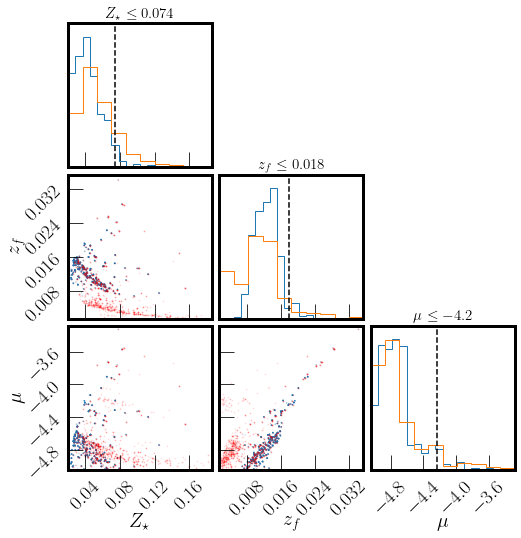

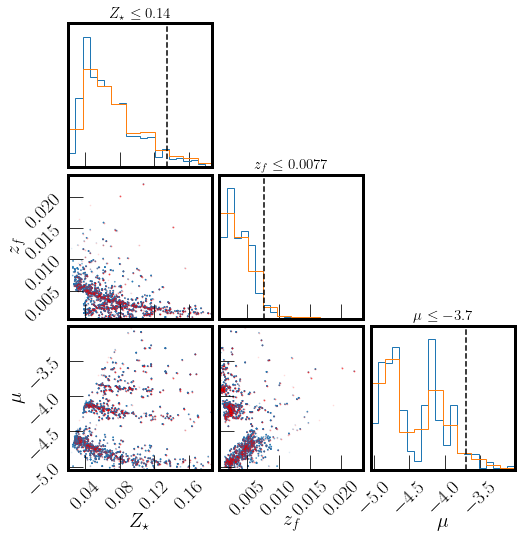

In [243]:
%matplotlib inline
corner_plot(nob_logu_outres,spock_outres_logu,weighted_outres_logu[:3],
            labels=["$Z_\star$", "$z_f$", "$\mu$"])
corner_plot(nob_logu_inres,spock_inres_logu,weighted_inres_logu[:3],
            labels=["$Z_\star$", "$z_f$", "$\mu$"])

In [162]:
(10**(-3.1))/1e-3

0.7943282347242813

## Figure 1 (rv)

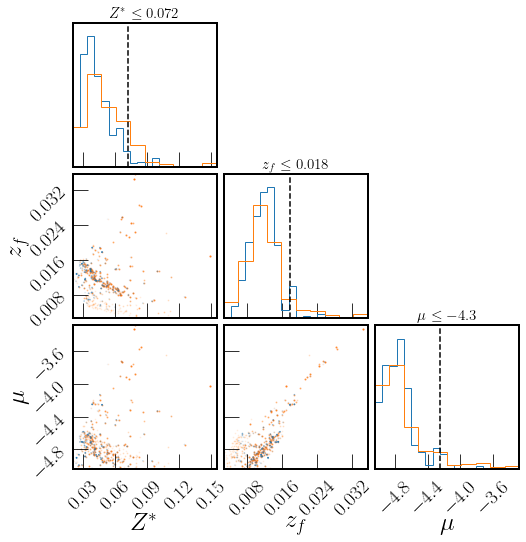

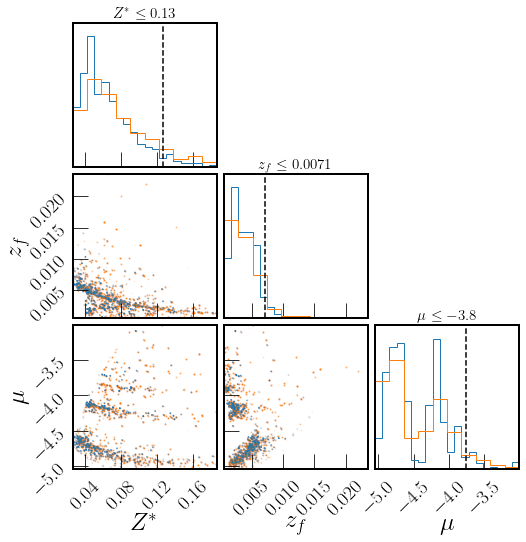

In [164]:
nob_rv_outres = [param[:3] for param in rv_list_outres]
nob_rv_inres = [param[:3] for param in rv_list_inres]

%matplotlib inline
corner_plot(nob_rv_outres,spock_outres_rv,weighted_outres_rv[:3],
            labels=["$Z^*$", "$z_f$", "$\mu$"])
corner_plot(nob_rv_inres,spock_inres_rv,weighted_inres_rv[:3],
            labels=["$Z^*$", "$z_f$", "$\mu$"])

# Figure 2 (Cat's eye plots)

In [129]:
j=3
k=1
np.random.seed(0)
phi_logu, Phinorm_logu = get_Phinorm(logu_inres)

8530it [03:19, 42.82it/s]


In [131]:
j=3
k=1
np.random.seed(0)
phi_rv, Phinorm_rv = get_Phinorm(rv_inres)

8725it [03:25, 42.36it/s]


In [144]:
np.shape(rv_inres)

(8725, 5)

Hmm... the code below shows that not all curves pass through the points. It's the same code as the last notebook. The only thing I can think of is that the integration isn't working properly. 

In [177]:
logu_inres_deltaT = np.array(logu_post_deltaT)[np.array(deltaH_cd_logu) < 0.0] 
logu_outres_deltaT = np.array(logu_post_deltaT)[np.array(deltaH_cd_logu) > 0.0]

rv_inres_deltaT = np.array(rv_post_deltaT)[np.array(deltaH_cd_rv) < 0.0] 
rv_outres_deltaT = np.array(rv_post_deltaT)[np.array(deltaH_cd_rv) > 0.0]

In [178]:
rv_inres_deltaT[0]

array([ 6.18350741e-02,  3.96798487e-03, -4.79736691e+00,  1.84373302e+03])

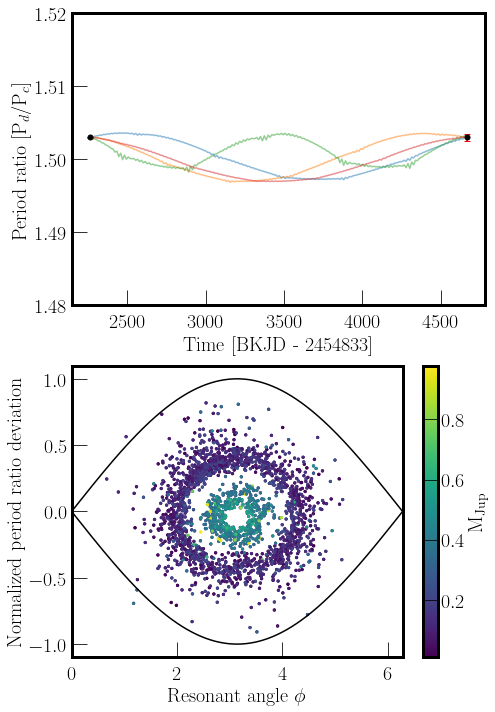

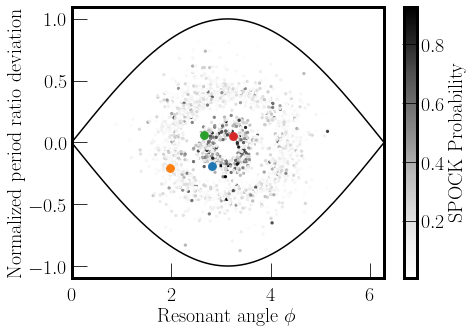

In [270]:
np.random.seed(110)
ind = np.random.randint(0, len(rv_inres_deltaT[spock_inres_rv != 0.0]), size=4)
time_grid = np.linspace(t_K2, t_tess, Nout)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

#ax1 = plt.subplot(2,1,1)
for param in rv_inres_deltaT[ind]:
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax[0].plot(time_grid,period_ratios,
         alpha=0.5,zorder=0, 
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax[0].errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=5, c='k',ecolor='r',zorder=1,capsize=3)
ax[0].set_ylabel('Period ratio [P$_d$/P$_c$]')
ax[0].set_ylim(1.48, 1.52)
#ax[0].set_ylim(1.501, 1.505)
ax[0].set_xlabel('Time [BKJD - 2454833]')
# ---
#ax2 = plt.subplot(2,1,2)
phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax[1].plot(phis, sep_upper, 'k')
ax[1].plot(phis, -sep_upper, 'k')
ax[1].set_xlim([0,2*np.pi])
ax[1].set_xlabel('Resonant angle $\phi$')
ax[1].set_ylabel('Normalized period ratio deviation')
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)

cb=ax[1].scatter(phi_rv[spock_inres_rv != 0.0], Phinorm_rv[spock_inres_rv != 0.0], 
              c=[(10**(param[2]))/1e-3 for param in rv_inres[spock_inres_rv != 0.0]], 
              s=5)
ax[1].scatter(phi_rv[spock_inres_rv != 0.0], Phinorm_rv[spock_inres_rv != 0.0], 
              c=[param[2] for param in rv_inres[spock_inres_rv != 0.0]], 
              s=5)

fig.colorbar(cb).set_label(r'$\rm{M}_{\rm Jup}$')

plt.tight_layout()

fig, ax = plt.subplots(figsize=(7,5))
phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax.plot(phis, sep_upper, 'k')
ax.plot(phis, -sep_upper, 'k')
ax.set_xlim([0,2*np.pi])
ax.set_xlabel('Resonant angle $\phi$')
ax.set_ylabel('Normalized period ratio deviation')
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
cb=ax.scatter(phi_rv[spock_inres_rv != 0.0], Phinorm_rv[spock_inres_rv != 0.0], 
              c=[prob for prob in spock_inres_rv[spock_inres_rv != 0.0]],cmap='Greys', 
              s=5)            

for phi, Phinorm in zip(phi_rv[spock_inres_rv != 0.0][ind],Phinorm_rv[spock_inres_rv != 0.0][ind]):
    ax.scatter(phi, Phinorm, s=60)
    
fig.colorbar(cb).set_label(r'SPOCK Probability')


#ax.scatter(phi[spock_prob == 0.0], Phinorm[spock_prob == 0.0], c='C1', alpha=0.2, s=20)
#cb.set_label('your label here')
#fig.colorbar(cb).set_label(r'$\rm{M}_{\rm Jup}$')

In [271]:
rv_inres_deltaT[ind]

array([[ 4.41302858e-02,  5.74420917e-03, -4.70577229e+00,
         1.56864263e+03],
       [ 5.78936077e-02,  4.63665155e-03, -4.75844251e+00,
         1.82315790e+03],
       [ 4.70162679e-02,  3.40355964e-03, -4.22738333e+00,
         1.10983991e+02],
       [ 7.93773939e-02,  3.35091556e-03, -4.96418789e+00,
         1.19769117e+02]])

## Investigating unstable non-resonant, low-zfree values

In [256]:
unstable = np.array(logu_outres_deltaT)[spock_outres_logu == 0.0]
zfree = [unstable[i][1] for i in range(len(unstable))]
low_zfree = np.array(unstable)[np.array(zfree) < 0.008]

In [257]:
len(low_zfree)

713

In [258]:
logu_outres_deltaT[0]

array([ 5.17319852e-02,  4.84538393e-03, -4.86732172e+00,  1.48327970e+02])

<ErrorbarContainer object of 3 artists>

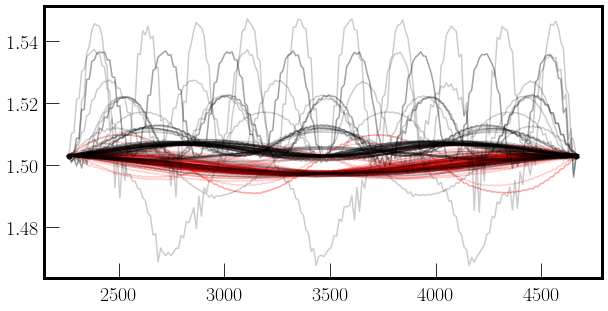

In [259]:
np.random.seed(50)
ind1 = np.random.randint(0, len(low_zfree), size=100)
ind2 = np.random.randint(0, len(logu_outres_deltaT), size=100)
time_grid = np.linspace(t_K2, t_tess, Nout)

fig, ax = plt.subplots(figsize=(10,5))

#ax1 = plt.subplot(2,1,1)
for param in logu_outres_deltaT[ind2]:
    p = param[:4]

    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))

    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)

    ax.plot(time_grid,period_ratios,c='k',
         alpha=0.2,zorder=1, 
         rasterized=True)
    
for param in low_zfree[ind1]:
    p = param[:4]

    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))

    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)

    ax.plot(time_grid,period_ratios,c='r',
         alpha=0.2,zorder=0, 
         rasterized=True)


ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=5, c='k',ecolor='r',zorder=1,capsize=3)

# Testing the priors on b

We want to quantify how much $\mu$ changes by inserting planet b's parameters. Early results showed that it affected $\mu$, but not by much. How do the lower bounds on planet b shape $\mu$?

## Plotting original rejection posterior of $\mu$: $\log{(\mathcal{U})} \sim (3 M_\oplus, 1 M_\rm{Jup})$

In [7]:
path = 'rejection_sampling_posteriors/batches_3Mearth_1Mjup_c_d_25mil/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
mus = [like_output[i][-1] for i in range(len(like_output))]
deltaTs = [like_output[i][2] for i in range(len(like_output))]

like_output = []

for p,mu,T in zip(params,mus,deltaTs):
    r = list(p)
    r.append(mu)
    r.append(T)
    
    like_output.append(r)

ValueError: need at least one array to concatenate

In [393]:
like_output[0]

[0.004612862593096371,
 0.00753431957339358,
 -4.905672617510811,
 624.6987808764719]

In [394]:
like_output_list = [list(s) for s in like_output]

for j in like_output_list:
    del j[-1]

In [395]:
sigma=0.997
sigma_list = [float(DescrStatsW(data=np.array(like_output_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(like_output_list)[1])]

In [396]:
(10**sigma_list[2])/9.46e-4

0.7723244768849301

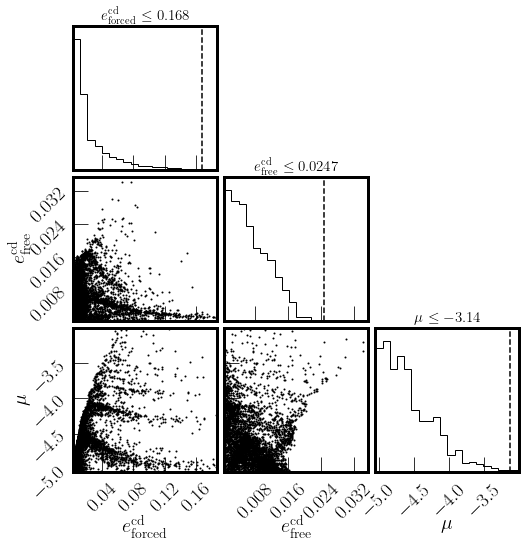

In [397]:
ndim = np.shape(like_output_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(like_output_list), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(like_output_list)[:,xi], np.array(like_output_list)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(sigma_list[i]), fontsize=15)
    ax.axvline(x=sigma_list[i], ls='--',color='k')

In [398]:
(10**(-3.14))/9.54e-4

0.7593668344601571

In [399]:
(10**(-3.2))/9.54e-4

0.6613808642350031

In [400]:
(10**(-3.01))/9.54e-4

1.0243576739578732

In [401]:
(10**(-3.46))/9.54e-4

0.3634558180844148

### Res vs. non-res for original rejection posterior

In [407]:
deltaH_cd_likepost = get_deltaH(like_output,j=3, k=1, i1=1, i2=2, pl_b=False)

0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
4607it [00:45, 101.42it/s]


In [409]:
inres = np.array(like_output)[np.array(deltaH_cd_likepost) < 0.0] 
outres = np.array(like_output)[(np.array(deltaH_cd_likepost) >= 0.0) | np.isnan(np.array(deltaH_cd_likepost))]

print(len(inres))
print(len(outres))

945
3662


In [444]:
inres_list = [list(s) for s in inres]

for j in inres_list:
    del j[-1]

outres_list = [list(s) for s in outres]

for j in outres_list:
    del j[-1]

In [448]:
inres_list[0]

[0.1759898730579736, 0.0016156659064438966, -4.986355506380253]

In [449]:
sigma=0.997
threesig_inres = [float(DescrStatsW(data=np.array(inres_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in \
              range(np.shape(inres_list)[1])]
threesig_outres = [float(DescrStatsW(data=np.array(outres_list)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in \
              range(np.shape(outres_list)[1])]

In [450]:
print(threesig_inres)
print('\n')
print(threesig_outres)

[0.1856968438457781, 0.02853087937539518, -3.039247418218122]


[0.07698884866116444, 0.023094892185504583, -3.193458933940142]


In [452]:
print((10**(threesig_inres[-1]))/9.54e-4)
print((10**(threesig_outres[-1]))/9.54e-4)

0.9576442537722625
0.6714175536957531


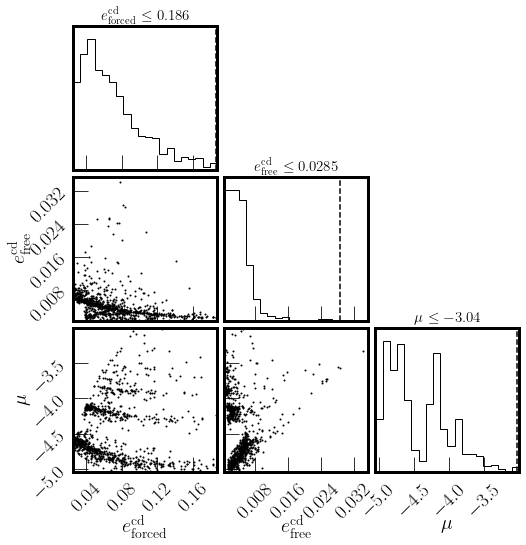

In [455]:
ndim = np.shape(inres_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(inres_list), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(inres_list)[:,xi], np.array(inres_list)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_inres[i]), fontsize=15)
    ax.axvline(x=threesig_inres[i], ls='--',color='k')
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

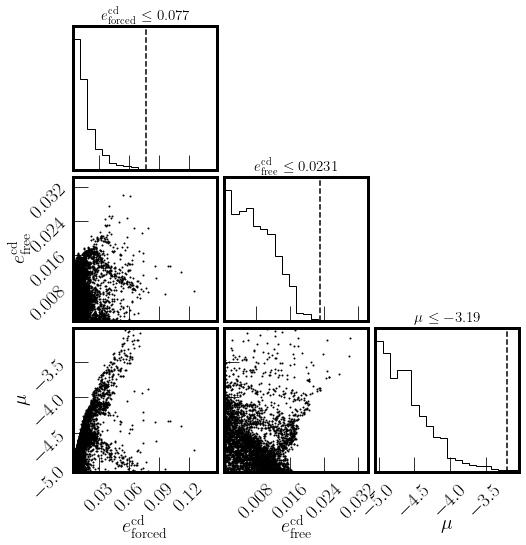

In [464]:
ndim = np.shape(outres_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(outres_list), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(outres_list)[:,xi], np.array(outres_list)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_outres[i]), fontsize=15)
    ax.axvline(x=threesig_outres[i], ls='--',color='k')
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

100it [00:03, 32.49it/s]


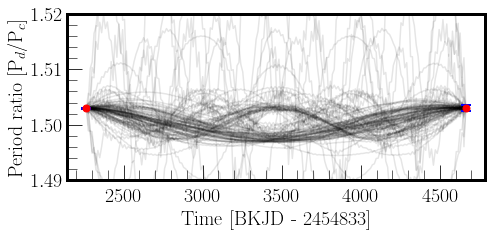

In [469]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(inres[:100])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

In [1]:
fig = plt.figure(1,figsize=(3.2*3.4, 2.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(outres[:100])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

NameError: name 'plt' is not defined

## Prior sensitivity on $\mu$: $\log{(\mathcal{U})} \sim (10 M_\oplus, 1 M_\rm{Jup})$

In [201]:
path2 = 'lnlike_test_posteriors/batches_10Mearth_1Mjup_c_d_30mil/'
params2 = [np.load(file, allow_pickle=True) for file in glob.iglob(path2+'/*.npy', recursive=True)]


par_con2 = np.concatenate(params2)

like_output2 = par_con2[pd.notnull(par_con2)]

print(len(like_output2))

params2 = [list(like_output2[i][:2]) for i in range(len(like_output2))]
mus2 = [np.log10((10**like_output2[i][-1])/9.54e-4) for i in range(len(like_output2))]
deltaTs2 = [like_output2[i][2] for i in range(len(like_output2))]

like_output2 = []

for p,mu,T in zip(params2,mus2,deltaTs2):
    r = list(p) 
    r.append(mu)
    r.append(T)
    
    like_output2.append(r)

2331


In [202]:
like_output2[0]

[0.01437951706187847,
 0.008743258075850975,
 -1.2577745122930524,
 1317.6448917173018]

In [203]:
like_output_list2 = [list(s) for s in like_output2]

for j in like_output_list2:
    del j[-1]

In [204]:
sigma=0.997
two_sigma = [float(DescrStatsW(data=np.array(like_output_list2)[:,i]).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(like_output_list2)[1])]

In [209]:
(10**two_sigma[2])

0.9002031095811793

Note: $\mu$ is in log of jupiter masses!! So 0 is 1 Mjup below.

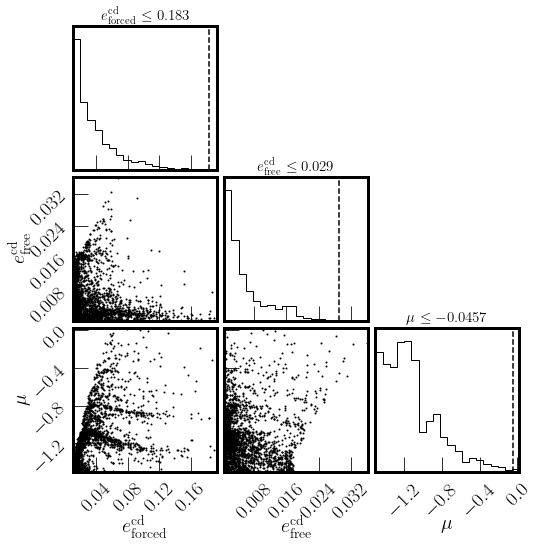

In [214]:
ndim = np.shape(like_output_list)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(like_output_list2), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False
    #weights=preds_arr
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(like_output_list2)[:,xi], np.array(like_output_list2)[:,yi], s=1,
                   color="k", alpha=1.0#*preds_arr[np.where(preds_arr != 0.0)], s=1
                  )
        #ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
        #           color="C1", 
        #           alpha=0.05, s=1)
        #if yi==2:
        #    ax.set_yscale('log')
            
        #if xi==2 and yi==2:
        #    ax.set_yticklabels([])

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(two_sigma[i]), fontsize=15)
    ax.axvline(x=two_sigma[i], ls='--',color='k')

## RV Sampling: $m_b \sim \mathcal{N(0.64, 0.19)},\ e \sim \mathcal{U}(0, 0.3)$

### Sampler function

In [125]:
def sampler(nsamples, post_array, bmass_lims=[8.964e-6, 3e-3],e_b=False, pl_e=False, e_e=False, rv_params=False):
    
    sim_list = []
    indices = []
    
    pbar = tqdm(total=nsamples)
    
    while len(sim_list) < nsamples:
        
        if rv_params:
            # Mascareño et al. (2021) values:

            m_b = float(stats.norm.rvs(loc=0.64, scale=0.19))*1e-3
            #e_b = float(stats.norm.rvs(loc=0.13, scale=0.07))
            #m_b = float(stats.loguniform.rvs(8.964e-6, 3e-3, size=1))

            if e_b:
                e_b = float(stats.norm.rvs(loc=0.13, scale=0.07))
            #elif e_b_flat:
            #    e_b = float(np.random.uniform(0, 0.3, size=1))  
            else: 
                e_b = 0.0

            if m_b < 0 or e_b < 0.0:
                    continue
            if pl_e:
                m_e = float(stats.norm.rvs(loc=1.16, scale=0.3))*1e-3
                e_e = float(stats.norm.rvs(loc=0.1, scale=0.09))
                P_e = float(stats.norm.rvs(loc=50.29, scale=6.62))

                if m_e < 0 or e_e < 0.0 or P_e < 0.0:
                    continue
        else:
        # Wide values:
            m_b = float(stats.loguniform.rvs(float(bmass_lims[0]), float(bmass_lims[1]), size=1))

            if e_b:
                e_b = float(np.random.uniform(0, 0.3, size=1))  
            else: 
                e_b = 0.0
            
            if m_b < 0 or e_b < 0.0:
                    continue
                
            if pl_e:
                m_e = float(stats.loguniform.rvs(3e-5, 3e-3, size=1))
                #P_e = float(stats.norm.rvs(loc=50.29, scale=6.62))
                P_e = float(np.random.uniform(40, 70, size=1)) 
                
                if e_e:
                    e_e = float(np.random.uniform(0, 0.3, size=1))
                else:
                    e_e = 0.0
                
                if m_e < 0 or e_e < 0.0 or P_e < 0.0:
                    continue

        # selecting random sample from the MLE posteriors:
        ind = int(np.random.randint(0, len(post_array), size=1))
        sim = makesim(post_array[ind])
        
        pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
        sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        if pl_e:
            pomega_e = float(np.random.uniform(0, 2*np.pi, size=1))
            pl_e_period = P_e/sim.particles[3].P
            sim.add(m=m_e, P=pl_e_period, e=e_e, pomega=pomega_e, theta=np.pi/2)
            
        sim.move_to_com()

        sim_list.append(sim)
        indices.append(ind) # important to keep for later

        pbar.update()
    pbar.close()
    
    return sim_list, indices
            
def spock_pred(simlist):
    model = FeatureClassifier()
    return model.predict_stable(simlist)

def weighted_results(sims, indices, sigma, post_array, ecc_b=False, pl_e=False, ecc_e=False):
    pred = spock_pred(sims)
    
    # planet b posteriors
    M_b = [np.log10(s.particles[-1].m) for s in sims]
    e_b = [s.particles[-1].e for s in sims]
        
    
    if pl_e:
        
        M_b = [np.log10(s.particles[-2].m) for s in sims]
        e_b = [s.particles[-2].e for s in sims]
        
        P_e = [s.particles[-1].P*s.particles[-2].P  for s in sims]
        M_e = [np.log10(s.particles[-1].m) for s in sims]
        e_e = [s.particles[-1].e for s in sims]
        
    
    s = np.array(post_array)[indices]

    s_results = []
    for i,r in enumerate(s):
        p = list(r)
        p.append(M_b[i])
        if ecc_b:
            p.append(e_b[i])
        if pl_e:
            p.append(P_e[i])
            p.append(M_e[i])
            if ecc_e:
                p.append(e_e[i])
        s_results.append(p)
        
    for j in s_results:
        del j[3]
    # calculating upper bounds using the SPOCK probabilities as weights
    sigma_list = [float(DescrStatsW(data=np.array(s_results)[:,i], 
                         weights=pred).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results)[1])]
    
    return s_results, pred, sigma_list

In [126]:
Nsamps = 50000

In [127]:
m_b_2sigma_rv = np.log10((0.64+3*0.19)*1e-3)
e_b_2sigma_rv = 0.13+3*0.07

In [128]:
simlist_logu, indices_logu = sampler(Nsamps, like_output, e_b=True)



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 14/50000 [00:00<06:19, 131.81it/s]

  0%|          | 28/50000 [00:00<06:37, 125.84it/s]

  0%|          | 41/50000 [00:00<06:37, 125.61it/s]

  0%|          | 54/50000 [00:00<06:42, 124.08it/s]

  0%|          | 69/50000 [00:00<06:21, 130.74it/s]

  0%|          | 83/50000 [00:00<06:24, 129.71it/s]

  0%|          | 97/50000 [00:00<06:17, 132.19it/s]

  0%|          | 111/50000 [00:00<06:14, 133.27it/s]

  0%|          | 125/50000 [00:00<06:12, 133.80it/s]

  0%|          | 139/50000 [00:01<06:16, 132.39it/s]

  0%|          | 153/50000 [00:01<06:12, 133.69it/s]

  0%|          | 167/50000 [00:01<06:21, 130.79it/s]

  0%|          | 181/50000 [00:01<06:37, 125.46it/s]

  0%|          | 194/50000 [00:01<06:39, 124.57it/s]

  0%|          | 207/50000 [00:01<06:46, 122.41it/s]

  0%|          | 220/50000 [00:01<06:51, 120.84it/s]

  0%|          | 233/50000 [00:01<06:50, 121.29it/s]

  0%|          | 246/50000 [00:01<06:57, 119

  7%|▋         | 3590/50000 [00:28<06:13, 124.21it/s]

  7%|▋         | 3603/50000 [00:28<06:14, 123.82it/s]

  7%|▋         | 3616/50000 [00:28<06:23, 121.02it/s]

  7%|▋         | 3629/50000 [00:28<06:15, 123.47it/s]

  7%|▋         | 3642/50000 [00:29<06:14, 123.88it/s]

  7%|▋         | 3656/50000 [00:29<06:06, 126.54it/s]

  7%|▋         | 3669/50000 [00:29<06:05, 126.87it/s]

  7%|▋         | 3682/50000 [00:29<06:21, 121.28it/s]

  7%|▋         | 3695/50000 [00:29<06:27, 119.64it/s]

  7%|▋         | 3708/50000 [00:29<06:28, 119.17it/s]

  7%|▋         | 3721/50000 [00:29<06:26, 119.67it/s]

  7%|▋         | 3736/50000 [00:29<06:05, 126.50it/s]

  7%|▋         | 3749/50000 [00:29<06:08, 125.61it/s]

  8%|▊         | 3762/50000 [00:30<06:06, 126.03it/s]

  8%|▊         | 3775/50000 [00:30<06:05, 126.46it/s]

  8%|▊         | 3788/50000 [00:30<06:24, 120.14it/s]

  8%|▊         | 3801/50000 [00:30<06:22, 120.81it/s]

  8%|▊         | 3814/50000 [00:30<06:21, 121.19it/s]

  8%|▊    

 15%|█▍        | 7280/50000 [00:57<05:18, 133.93it/s]

 15%|█▍        | 7294/50000 [00:57<05:25, 131.30it/s]

 15%|█▍        | 7308/50000 [00:57<05:29, 129.63it/s]

 15%|█▍        | 7321/50000 [00:57<05:29, 129.66it/s]

 15%|█▍        | 7335/50000 [00:57<05:23, 131.84it/s]

 15%|█▍        | 7350/50000 [00:57<05:15, 135.36it/s]

 15%|█▍        | 7364/50000 [00:57<05:18, 133.67it/s]

 15%|█▍        | 7378/50000 [00:57<05:19, 133.44it/s]

 15%|█▍        | 7392/50000 [00:57<05:16, 134.52it/s]

 15%|█▍        | 7406/50000 [00:58<05:13, 135.99it/s]

 15%|█▍        | 7420/50000 [00:58<05:16, 134.56it/s]

 15%|█▍        | 7434/50000 [00:58<05:16, 134.50it/s]

 15%|█▍        | 7448/50000 [00:58<05:24, 130.95it/s]

 15%|█▍        | 7462/50000 [00:58<05:20, 132.82it/s]

 15%|█▍        | 7476/50000 [00:58<05:24, 130.95it/s]

 15%|█▍        | 7490/50000 [00:58<05:24, 131.07it/s]

 15%|█▌        | 7504/50000 [00:58<05:18, 133.38it/s]

 15%|█▌        | 7518/50000 [00:58<05:14, 134.97it/s]

 15%|█▌   

 22%|██▏       | 11022/50000 [01:25<05:01, 129.36it/s]

 22%|██▏       | 11036/50000 [01:25<04:57, 131.02it/s]

 22%|██▏       | 11050/50000 [01:25<05:03, 128.33it/s]

 22%|██▏       | 11064/50000 [01:25<04:56, 131.17it/s]

 22%|██▏       | 11078/50000 [01:25<04:55, 131.52it/s]

 22%|██▏       | 11092/50000 [01:26<04:59, 129.74it/s]

 22%|██▏       | 11106/50000 [01:26<04:58, 130.24it/s]

 22%|██▏       | 11120/50000 [01:26<05:00, 129.52it/s]

 22%|██▏       | 11134/50000 [01:26<04:56, 130.95it/s]

 22%|██▏       | 11148/50000 [01:26<04:58, 130.34it/s]

 22%|██▏       | 11162/50000 [01:26<05:00, 129.05it/s]

 22%|██▏       | 11175/50000 [01:26<05:00, 129.24it/s]

 22%|██▏       | 11189/50000 [01:26<04:56, 131.06it/s]

 22%|██▏       | 11203/50000 [01:26<04:58, 129.84it/s]

 22%|██▏       | 11218/50000 [01:27<04:50, 133.45it/s]

 22%|██▏       | 11232/50000 [01:27<04:54, 131.76it/s]

 22%|██▏       | 11246/50000 [01:27<04:52, 132.42it/s]

 23%|██▎       | 11260/50000 [01:27<04:53, 132.1

 29%|██▉       | 14728/50000 [01:53<04:32, 129.27it/s]

 29%|██▉       | 14742/50000 [01:53<04:31, 130.04it/s]

 30%|██▉       | 14756/50000 [01:53<04:28, 131.27it/s]

 30%|██▉       | 14771/50000 [01:53<04:23, 133.64it/s]

 30%|██▉       | 14785/50000 [01:54<04:29, 130.73it/s]

 30%|██▉       | 14799/50000 [01:54<04:34, 128.21it/s]

 30%|██▉       | 14812/50000 [01:54<04:41, 124.86it/s]

 30%|██▉       | 14827/50000 [01:54<04:29, 130.49it/s]

 30%|██▉       | 14841/50000 [01:54<04:26, 131.71it/s]

 30%|██▉       | 14855/50000 [01:54<04:31, 129.27it/s]

 30%|██▉       | 14868/50000 [01:54<04:37, 126.73it/s]

 30%|██▉       | 14881/50000 [01:54<04:37, 126.53it/s]

 30%|██▉       | 14894/50000 [01:54<04:39, 125.59it/s]

 30%|██▉       | 14907/50000 [01:55<04:38, 126.20it/s]

 30%|██▉       | 14920/50000 [01:55<04:36, 126.88it/s]

 30%|██▉       | 14935/50000 [01:55<04:27, 130.90it/s]

 30%|██▉       | 14949/50000 [01:55<04:28, 130.60it/s]

 30%|██▉       | 14963/50000 [01:55<04:32, 128.3

 37%|███▋      | 18394/50000 [02:21<03:57, 132.82it/s]

 37%|███▋      | 18408/50000 [02:21<03:59, 132.18it/s]

 37%|███▋      | 18422/50000 [02:22<03:59, 131.94it/s]

 37%|███▋      | 18436/50000 [02:22<03:59, 131.81it/s]

 37%|███▋      | 18450/50000 [02:22<03:58, 132.02it/s]

 37%|███▋      | 18464/50000 [02:22<04:00, 131.26it/s]

 37%|███▋      | 18478/50000 [02:22<03:59, 131.72it/s]

 37%|███▋      | 18492/50000 [02:22<03:59, 131.80it/s]

 37%|███▋      | 18506/50000 [02:22<04:02, 129.98it/s]

 37%|███▋      | 18520/50000 [02:22<04:03, 129.13it/s]

 37%|███▋      | 18535/50000 [02:22<03:55, 133.70it/s]

 37%|███▋      | 18549/50000 [02:22<04:04, 128.43it/s]

 37%|███▋      | 18563/50000 [02:23<04:03, 128.99it/s]

 37%|███▋      | 18576/50000 [02:23<04:04, 128.41it/s]

 37%|███▋      | 18590/50000 [02:23<04:03, 129.12it/s]

 37%|███▋      | 18605/50000 [02:23<03:53, 134.49it/s]

 37%|███▋      | 18619/50000 [02:23<03:53, 134.66it/s]

 37%|███▋      | 18633/50000 [02:23<03:52, 134.9

 44%|████▍     | 21975/50000 [02:49<03:32, 131.80it/s]

 44%|████▍     | 21990/50000 [02:49<03:27, 135.01it/s]

 44%|████▍     | 22004/50000 [02:50<03:30, 133.10it/s]

 44%|████▍     | 22018/50000 [02:50<03:33, 130.86it/s]

 44%|████▍     | 22032/50000 [02:50<03:33, 131.05it/s]

 44%|████▍     | 22046/50000 [02:50<03:37, 128.55it/s]

 44%|████▍     | 22059/50000 [02:50<03:38, 127.87it/s]

 44%|████▍     | 22074/50000 [02:50<03:30, 132.47it/s]

 44%|████▍     | 22088/50000 [02:50<03:30, 132.84it/s]

 44%|████▍     | 22102/50000 [02:50<03:30, 132.83it/s]

 44%|████▍     | 22116/50000 [02:50<03:28, 133.79it/s]

 44%|████▍     | 22130/50000 [02:50<03:28, 133.97it/s]

 44%|████▍     | 22144/50000 [02:51<03:32, 130.97it/s]

 44%|████▍     | 22158/50000 [02:51<03:33, 130.65it/s]

 44%|████▍     | 22172/50000 [02:51<03:29, 132.57it/s]

 44%|████▍     | 22186/50000 [02:51<03:29, 133.07it/s]

 44%|████▍     | 22200/50000 [02:51<03:32, 130.75it/s]

 44%|████▍     | 22214/50000 [02:51<03:35, 128.8

 51%|█████     | 25450/50000 [03:18<03:25, 119.18it/s]

 51%|█████     | 25462/50000 [03:18<03:27, 118.33it/s]

 51%|█████     | 25474/50000 [03:18<03:29, 116.88it/s]

 51%|█████     | 25486/50000 [03:18<03:33, 114.57it/s]

 51%|█████     | 25498/50000 [03:18<03:32, 115.57it/s]

 51%|█████     | 25510/50000 [03:18<03:31, 115.97it/s]

 51%|█████     | 25523/50000 [03:18<03:28, 117.68it/s]

 51%|█████     | 25536/50000 [03:18<03:28, 117.48it/s]

 51%|█████     | 25548/50000 [03:18<03:34, 114.05it/s]

 51%|█████     | 25560/50000 [03:19<03:35, 113.23it/s]

 51%|█████     | 25573/50000 [03:19<03:30, 116.27it/s]

 51%|█████     | 25585/50000 [03:19<03:29, 116.57it/s]

 51%|█████     | 25599/50000 [03:19<03:21, 121.25it/s]

 51%|█████     | 25612/50000 [03:19<03:17, 123.72it/s]

 51%|█████▏    | 25625/50000 [03:19<03:19, 121.99it/s]

 51%|█████▏    | 25638/50000 [03:19<03:23, 119.98it/s]

 51%|█████▏    | 25651/50000 [03:19<03:20, 121.58it/s]

 51%|█████▏    | 25664/50000 [03:19<03:26, 118.1

 58%|█████▊    | 29121/50000 [03:46<02:39, 130.94it/s]

 58%|█████▊    | 29135/50000 [03:46<02:42, 128.59it/s]

 58%|█████▊    | 29149/50000 [03:46<02:40, 130.05it/s]

 58%|█████▊    | 29164/50000 [03:46<02:36, 133.53it/s]

 58%|█████▊    | 29178/50000 [03:46<02:35, 133.88it/s]

 58%|█████▊    | 29192/50000 [03:46<02:34, 134.50it/s]

 58%|█████▊    | 29206/50000 [03:46<02:36, 132.57it/s]

 58%|█████▊    | 29220/50000 [03:46<02:39, 130.13it/s]

 58%|█████▊    | 29235/50000 [03:47<02:34, 134.50it/s]

 58%|█████▊    | 29249/50000 [03:47<02:32, 136.06it/s]

 59%|█████▊    | 29263/50000 [03:47<02:35, 133.37it/s]

 59%|█████▊    | 29278/50000 [03:47<02:32, 135.92it/s]

 59%|█████▊    | 29292/50000 [03:47<02:34, 133.83it/s]

 59%|█████▊    | 29306/50000 [03:47<02:35, 132.88it/s]

 59%|█████▊    | 29320/50000 [03:47<02:36, 132.19it/s]

 59%|█████▊    | 29335/50000 [03:47<02:31, 136.06it/s]

 59%|█████▊    | 29349/50000 [03:47<02:36, 132.33it/s]

 59%|█████▊    | 29363/50000 [03:47<02:35, 132.8

 66%|██████▌   | 32838/50000 [04:14<02:08, 133.54it/s]

 66%|██████▌   | 32852/50000 [04:14<02:10, 131.87it/s]

 66%|██████▌   | 32866/50000 [04:14<02:08, 133.36it/s]

 66%|██████▌   | 32880/50000 [04:14<02:06, 135.25it/s]

 66%|██████▌   | 32895/50000 [04:14<02:04, 137.40it/s]

 66%|██████▌   | 32910/50000 [04:14<02:03, 138.74it/s]

 66%|██████▌   | 32924/50000 [04:14<02:07, 134.03it/s]

 66%|██████▌   | 32938/50000 [04:14<02:05, 135.54it/s]

 66%|██████▌   | 32952/50000 [04:15<02:10, 130.32it/s]

 66%|██████▌   | 32966/50000 [04:15<02:10, 130.38it/s]

 66%|██████▌   | 32980/50000 [04:15<02:10, 130.51it/s]

 66%|██████▌   | 32994/50000 [04:15<02:12, 128.12it/s]

 66%|██████▌   | 33007/50000 [04:15<02:12, 128.62it/s]

 66%|██████▌   | 33021/50000 [04:15<02:09, 131.21it/s]

 66%|██████▌   | 33035/50000 [04:15<02:09, 130.64it/s]

 66%|██████▌   | 33049/50000 [04:15<02:10, 130.18it/s]

 66%|██████▌   | 33063/50000 [04:15<02:12, 127.73it/s]

 66%|██████▌   | 33076/50000 [04:16<02:13, 126.8

 73%|███████▎  | 36565/50000 [04:42<01:39, 135.22it/s]

 73%|███████▎  | 36579/50000 [04:42<01:38, 136.00it/s]

 73%|███████▎  | 36593/50000 [04:42<01:39, 134.84it/s]

 73%|███████▎  | 36607/50000 [04:42<01:41, 132.36it/s]

 73%|███████▎  | 36621/50000 [04:42<01:39, 134.13it/s]

 73%|███████▎  | 36635/50000 [04:42<01:40, 133.34it/s]

 73%|███████▎  | 36650/50000 [04:42<01:37, 136.87it/s]

 73%|███████▎  | 36664/50000 [04:43<01:39, 133.83it/s]

 73%|███████▎  | 36679/50000 [04:43<01:37, 137.12it/s]

 73%|███████▎  | 36693/50000 [04:43<01:37, 136.69it/s]

 73%|███████▎  | 36707/50000 [04:43<01:36, 137.21it/s]

 73%|███████▎  | 36722/50000 [04:43<01:36, 138.19it/s]

 73%|███████▎  | 36736/50000 [04:43<01:37, 135.60it/s]

 74%|███████▎  | 36750/50000 [04:43<01:40, 131.54it/s]

 74%|███████▎  | 36764/50000 [04:43<01:41, 130.84it/s]

 74%|███████▎  | 36778/50000 [04:43<01:39, 132.92it/s]

 74%|███████▎  | 36792/50000 [04:44<01:40, 130.81it/s]

 74%|███████▎  | 36806/50000 [04:44<01:40, 131.7

 81%|████████  | 40285/50000 [05:10<01:13, 132.06it/s]

 81%|████████  | 40299/50000 [05:10<01:14, 130.41it/s]

 81%|████████  | 40313/50000 [05:10<01:15, 128.33it/s]

 81%|████████  | 40326/50000 [05:10<01:15, 127.83it/s]

 81%|████████  | 40340/50000 [05:10<01:14, 128.94it/s]

 81%|████████  | 40353/50000 [05:10<01:17, 124.51it/s]

 81%|████████  | 40367/50000 [05:11<01:16, 126.71it/s]

 81%|████████  | 40380/50000 [05:11<01:15, 127.47it/s]

 81%|████████  | 40394/50000 [05:11<01:13, 130.78it/s]

 81%|████████  | 40408/50000 [05:11<01:12, 131.80it/s]

 81%|████████  | 40422/50000 [05:11<01:12, 132.85it/s]

 81%|████████  | 40436/50000 [05:11<01:11, 134.38it/s]

 81%|████████  | 40450/50000 [05:11<01:10, 134.64it/s]

 81%|████████  | 40464/50000 [05:11<01:11, 133.07it/s]

 81%|████████  | 40478/50000 [05:11<01:12, 131.44it/s]

 81%|████████  | 40492/50000 [05:12<01:12, 130.97it/s]

 81%|████████  | 40506/50000 [05:12<01:11, 132.59it/s]

 81%|████████  | 40521/50000 [05:12<01:10, 134.7

 88%|████████▊ | 43997/50000 [05:38<00:44, 134.64it/s]

 88%|████████▊ | 44011/50000 [05:38<00:44, 134.24it/s]

 88%|████████▊ | 44025/50000 [05:38<00:44, 135.13it/s]

 88%|████████▊ | 44039/50000 [05:38<00:44, 134.22it/s]

 88%|████████▊ | 44053/50000 [05:38<00:44, 133.68it/s]

 88%|████████▊ | 44068/50000 [05:39<00:43, 136.28it/s]

 88%|████████▊ | 44082/50000 [05:39<00:43, 136.23it/s]

 88%|████████▊ | 44096/50000 [05:39<00:43, 134.28it/s]

 88%|████████▊ | 44111/50000 [05:39<00:43, 136.36it/s]

 88%|████████▊ | 44125/50000 [05:39<00:44, 132.72it/s]

 88%|████████▊ | 44139/50000 [05:39<00:43, 134.78it/s]

 88%|████████▊ | 44153/50000 [05:39<00:43, 134.11it/s]

 88%|████████▊ | 44168/50000 [05:39<00:42, 136.50it/s]

 88%|████████▊ | 44182/50000 [05:39<00:43, 135.02it/s]

 88%|████████▊ | 44196/50000 [05:39<00:43, 134.79it/s]

 88%|████████▊ | 44210/50000 [05:40<00:43, 131.69it/s]

 88%|████████▊ | 44224/50000 [05:40<00:43, 132.53it/s]

 88%|████████▊ | 44238/50000 [05:40<00:43, 133.2

 95%|█████████▌| 47717/50000 [06:06<00:16, 136.58it/s]

 95%|█████████▌| 47731/50000 [06:06<00:16, 135.07it/s]

 95%|█████████▌| 47745/50000 [06:06<00:17, 130.83it/s]

 96%|█████████▌| 47759/50000 [06:06<00:16, 132.18it/s]

 96%|█████████▌| 47773/50000 [06:06<00:16, 132.63it/s]

 96%|█████████▌| 47787/50000 [06:07<00:16, 133.40it/s]

 96%|█████████▌| 47802/50000 [06:07<00:16, 135.11it/s]

 96%|█████████▌| 47817/50000 [06:07<00:15, 138.20it/s]

 96%|█████████▌| 47831/50000 [06:07<00:16, 135.09it/s]

 96%|█████████▌| 47845/50000 [06:07<00:16, 134.19it/s]

 96%|█████████▌| 47859/50000 [06:07<00:16, 132.53it/s]

 96%|█████████▌| 47873/50000 [06:07<00:16, 131.05it/s]

 96%|█████████▌| 47887/50000 [06:07<00:16, 130.39it/s]

 96%|█████████▌| 47901/50000 [06:07<00:16, 130.58it/s]

 96%|█████████▌| 47915/50000 [06:08<00:15, 130.65it/s]

 96%|█████████▌| 47929/50000 [06:08<00:15, 131.81it/s]

 96%|█████████▌| 47943/50000 [06:08<00:15, 133.35it/s]

 96%|█████████▌| 47957/50000 [06:08<00:15, 133.0

In [129]:
s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu,
                                                               indices_logu, 0.997, like_output, ecc_b=True)

 24%|██▍       | 12013/50000 [11:51<37:31, 16.87it/s] 


In [226]:
#three_sigma = [float(DescrStatsW(data=np.array(s_results_rv)[:,i], 
#                         weights=preds_rv).quantile(probs=np.array([0.997]), 
#                                                 return_pandas=False)) for i in range(np.shape(s_results_rv)[1])]

In [227]:
sigma_list[2]

-0.11585743937276265

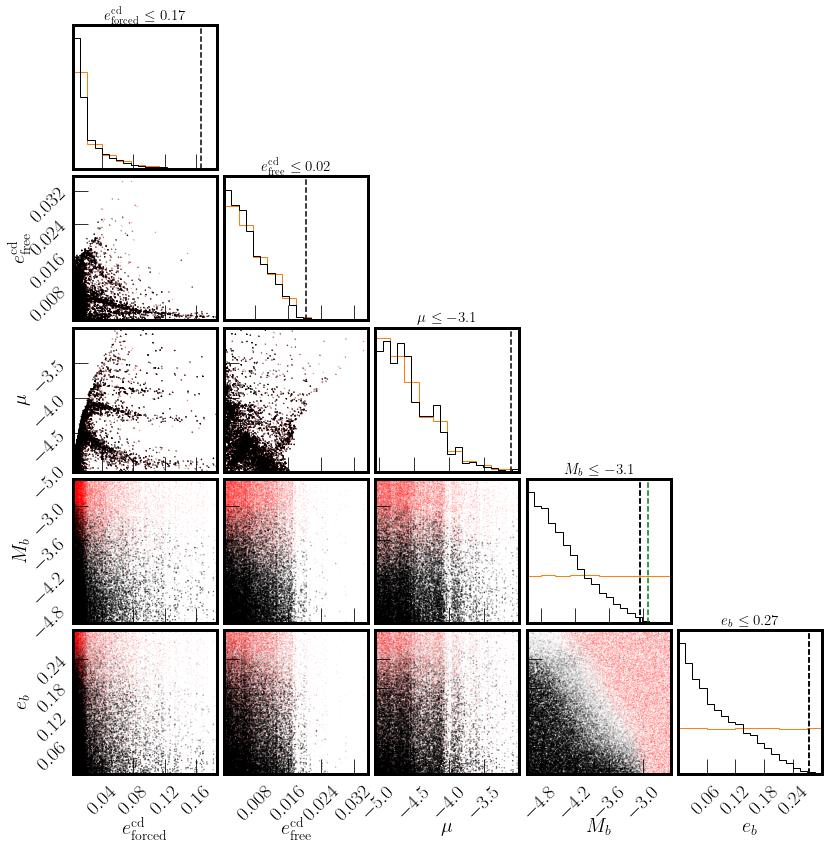

In [131]:
corner_plot(s_results_logu, preds_logu, sigma_list_logu, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

## RV Sampling: $m_b \sim \mathcal{N(0.64, 0.19)},\ e \sim \mathcal{N}(0.13, 0.07)$

In [24]:
Nsamps=50000

In [25]:
simlist_rv2, indices_rv2 = sampler(Nsamps, like_output, e_b=True, rv_params=True)


  8%|▊         | 3948/50000 [00:30<05:47, 132.45it/s]


 16%|█▌        | 7989/50000 [01:00<05:12, 134.23it/s]


 24%|██▍       | 11970/50000 [01:31<04:42, 134.69it/s]


 32%|███▏      | 15925/50000 [02:01<04:22, 129.91it/s]


 40%|███▉      | 19894/50000 [02:31<03:47, 132.56it/s]


 48%|████▊     | 23877/50000 [03:01<03:16, 132.71it/s]


 56%|█████▌    | 27856/50000 [03:31<02:43, 135.41it/s]


 64%|██████▎   | 31836/50000 [04:00<02:17, 131.82it/s]


 72%|███████▏  | 35816/50000 [04:30<01:48, 130.98it/s]


 80%|███████▉  | 39799/50000 [05:00<01:16, 132.73it/s]


 88%|████████▊ | 43784/50000 [05:30<00:46, 133.69it/s]


 95%|█████████▌| 47743/50000 [06:01<00:16, 132.92it/s]


100%|██████████| 50000/50000 [06:18<00:00, 132.19it/s]


In [26]:
s_results_rv2, preds_rv2, sigma_list_rv2 = weighted_results(simlist_rv2, 
                                                            indices_rv2, 0.997, like_output, ecc_b=True)

In [27]:
three_sigma = [float(DescrStatsW(data=np.array(s_results_rv2)[:,i], 
                         weights=preds_rv2).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_rv2)[1])]

In [122]:
print('Our $3\sigma$:', three_sigma[-1])
print('Mascareno+2021 RV:', 0.13+3*0.07)

print('Our $3\sigma$:', (10**three_sigma[-2])/9.54e-4)
print('Mascareno+2021 RV:', 0.64+3*0.19)

Our $3\sigma$: 0.18431767650375605
Mascareno+2021 RV: 0.34
Our $3\sigma$: 1.068227886176247
Mascareno+2021 RV: 1.21


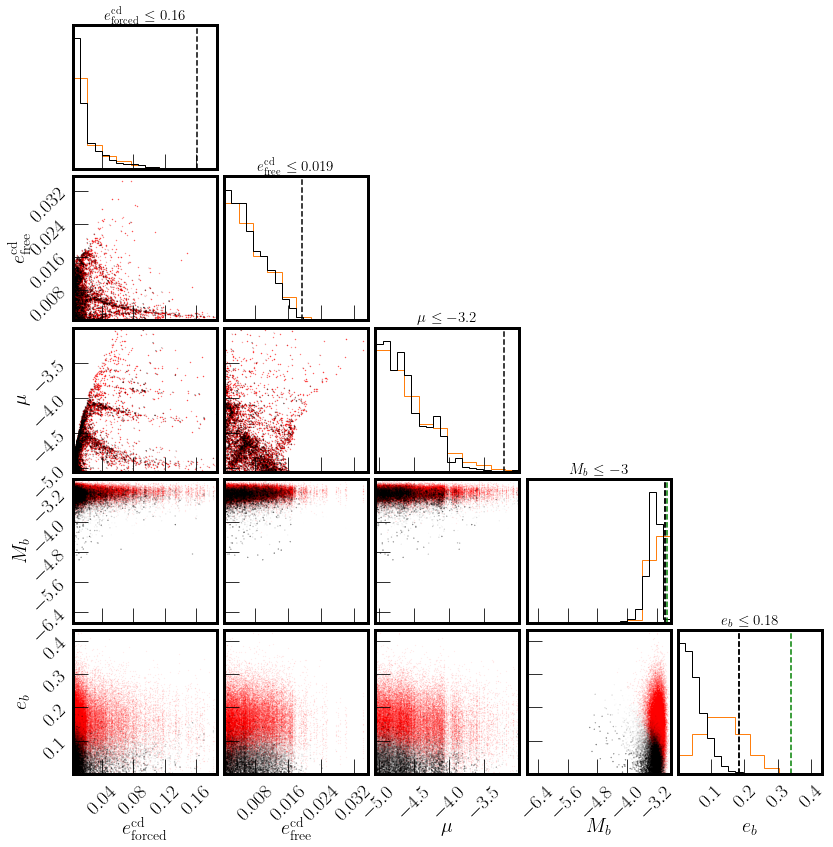

In [236]:
%matplotlib inline
corner_plot(s_results_rv2, preds_rv2, sigma_list_rv2, pl_b=True, ecc_b=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

[0.021006538339974883,
 0.011685504559996862,
 -4.881361183404963,
 -3.2797449661636295,
 0.13630107928246632]

In [103]:
def sres_2_post(like_post, s_res, indices):
    # rearranges the posterior order into a workable order for makesim and the other functions... don't ask. 
    
    deltaTs = [np.array(like_post)[indices][i][-1] for i in tqdm(range(len(np.array(like_post)[indices])))]
    
    post_res = []
    
    for i,param in enumerate(s_res):
        deltaT = deltaTs[i]
        res_params = param[:3]
        res_params.append(deltaT)

        post_res.append(res_params)
        
    mb_array = np.array([s_res[i][-2] for i in range(len(s_res))])
    eb_array = np.array([s_res[i][-1] for i in range(len(s_res))])
        
    post = np.c_[post_res,mb_array,eb_array]
        
    return post

### MMR space

In [107]:
rv_post2 = sres_2_post(like_output, s_results_rv2, indices_rv2)

100%|██████████| 50000/50000 [09:04<00:00, 91.80it/s]


In [311]:
rv_post2[0]

array([ 2.10065383e-02,  1.16855046e-02, -4.88136118e+00,  3.03541209e+02,
       -3.27974497e+00,  1.36301079e-01])

In [238]:
spock_prob_rv2 = preds_rv2

In [142]:
mb_array = (10**np.array([rv_post2[i][-2] for i in range(len(s_results_rv2))]))/9.54e-4
eb_array = np.array([rv_post2[i][-1] for i in range(len(s_results_rv2))])

In [ ]:
# c--d 3:2 resonance
deltaH_cd_rv2 = get_deltaH(rv_post2,j=3, k=1, i1=1, i2=2)

In [ ]:
# d--b 2:1 resonance
deltaH_db_rv2 = get_deltaH(rv_post2,j=2, k=1, i1=2, i2=3)

In [292]:
test = np.array(rv_post2)[(np.array(deltaH_cd_rv2) > 0.0) | np.isnan(np.array(deltaH_cd_rv2))]

In [295]:
len(test)+len(rv_inres)

50000

### Figure 1

In [297]:
rv_inres = np.array(rv_post2)[np.array(deltaH_cd_rv2) < 0.0] 
rv_outres = np.array(rv_post2)[(np.array(deltaH_cd_rv2) > 0.0) | np.isnan(np.array(deltaH_cd_rv2))]

spock_inres_rv = np.array(spock_prob_rv2)[np.array(deltaH_cd_rv2) < 0]
spock_outres_rv = np.array(spock_prob_rv2)[(np.array(deltaH_cd_rv2) > 0.0) | np.isnan(np.array(deltaH_cd_rv2))]

sigma=0.997

weighted_inres_rv = [float(DescrStatsW(data=np.array(rv_inres)[:,i],
                                          weights=spock_inres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_inres)[1])]
weighted_outres_rv = [float(DescrStatsW(data=np.array(rv_outres)[:,i],
                                          weights=spock_outres_rv).quantile(probs=np.array([sigma]), 
                                    return_pandas=False)) for i in range(np.shape(rv_outres)[1])]

In [473]:
print((10**weighted_inres_rv[-2])/9.54e-4)
print(weighted_inres_rv[-1])

1.0230480165966165
0.1759419441558315


In [474]:
print((10**weighted_outres_rv[-2])/9.54e-4)
print(weighted_outres_rv[-1])

1.0846684095664296
0.18639147828224362


In [298]:
nob_rv_inres = [param[:3] for param in rv_inres]
nob_rv_outres = [param[:3] for param in rv_outres]

In [310]:
nob_rv_inres[0]

array([ 4.02907126e-02,  1.08298120e-03, -4.10742393e+00])

In [299]:
len(nob_rv_outres)

39409

In [300]:
len(nob_rv_inres)

10591

<ipython-input-309-2c4a004e7def>:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure1b.pdf',dpi=300,bbox_inches='tight',padding=0)
<ipython-input-309-2c4a004e7def>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure1a.pdf',dpi=300,bbox_inches='tight',padding=0)


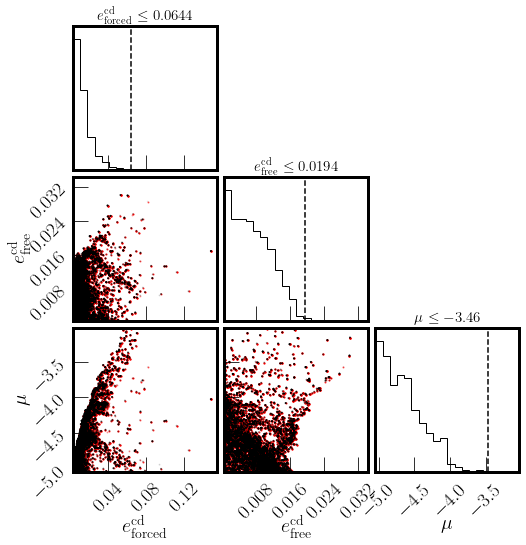

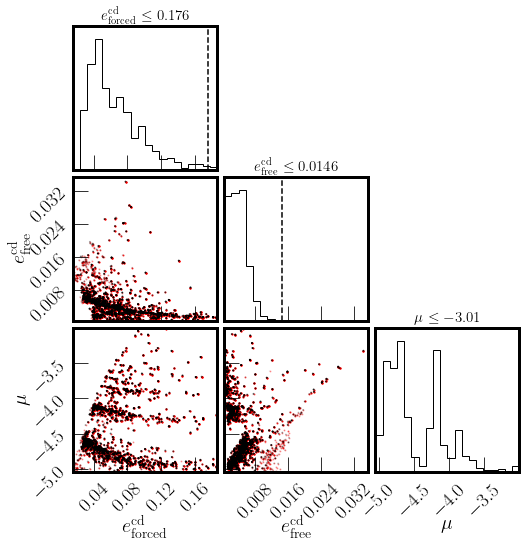

In [309]:
# outside resonance:
ndim = np.shape(nob_rv_outres)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(nob_rv_outres), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    weights=spock_outres_rv
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(nob_rv_outres)[:,xi], np.array(nob_rv_outres)[:,yi], s=1,
                   color="k", alpha=spock_outres_rv[spock_outres_rv != 0.0],
                  zorder=1)
        ax.scatter(np.array(nob_rv_outres)[:,xi][spock_outres_rv==0.0], 
                   np.array(nob_rv_outres)[:,yi][spock_outres_rv==0.0], 
                   color="r", 
                   alpha=0.3, s=1, zorder=0)

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(weighted_outres_rv[i]), fontsize=15)
    ax.axvline(x=weighted_outres_rv[i], ls='--',color='k')
    
plt.savefig('figures/Figure1b.pdf',dpi=300,bbox_inches='tight',padding=0)
    
################################
# in resonance:
ndim = np.shape(nob_rv_inres)[1]
#labels=["$Z_\star$", "$z_f$", "$\mu$ [$\log{\\rm{M}_{\\rm{Jup}}}$]"]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(nob_rv_inres), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    weights=spock_inres_rv
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(nob_rv_inres)[:,xi], np.array(nob_rv_inres)[:,yi], s=1,
                   color="k", alpha=spock_inres_rv[spock_inres_rv != 0.0],
                  zorder=1)
        ax.scatter(np.array(nob_rv_inres)[:,xi][spock_inres_rv==0.0], 
                   np.array(nob_rv_inres)[:,yi][spock_inres_rv==0.0], 
                   color="r", 
                   alpha=0.3, s=1, zorder=0)

#axes[2,2].set_yticklabels([])

for i in range(ndim):
    ax = axes[i, i]
    #ax.hist(np.array(priors)[:,i], color="C1", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(weighted_inres_rv[i]), fontsize=15)
    ax.axvline(x=weighted_inres_rv[i], ls='--',color='k')
    
plt.savefig('figures/Figure1a.pdf',dpi=300,bbox_inches='tight',padding=0)

### Figure 3

In [110]:
np.sum(~np.isnan(deltaH_db_rv2))

50000

In [132]:
logu_post2 = sres_2_post(like_output, s_results_logu, indices_logu)

100%|██████████| 50000/50000 [08:14<00:00, 101.20it/s]


In [143]:
mb_array_logu = (10**np.array([logu_post2[i][-2] for i in range(len(s_results_logu))]))/9.54e-4
eb_array_logu = np.array([logu_post2[i][-1] for i in range(len(s_results_logu))])

In [133]:
spock_prob_logu2 = preds_logu

In [136]:
deltaH_db_logu2 = get_deltaH(logu_post2,j=2, k=1, i1=2, i2=3)

9it [00:00, 83.35it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
50000it [09:01, 92.29it/s]


In [135]:
print(len(mb_array[spock_prob_rv2 > 0.0]))
print(len(mb_array_logu[spock_prob_logu2 > 0.0]))

15131
29879


In [190]:
print('Stable resonant:',len(mb_array[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] >= 0]))

Stable resonant: 93
Stable non-resonant: 15038


In [269]:
15038/(15038+93)

0.9938536778798494

In [191]:
print('Unstable resonant:',
      len(mb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] >= 0]))

Unstable resonant: 2977
Unstable non-resonant: 31892


In [307]:
print('Stable resonant:',
      len(mb_array_logu[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array_logu[spock_prob_logu2 > 0.0][(np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] >= 0)]))
print('\n')
print('Unstable resonant:',
      len(mb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] >= 0]))

Stable resonant: 68
Stable non-resonant: 29810


Unstable resonant: 6696
Unstable non-resonant: 12124


<ipython-input-287-9810d0dd296d>:92: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)


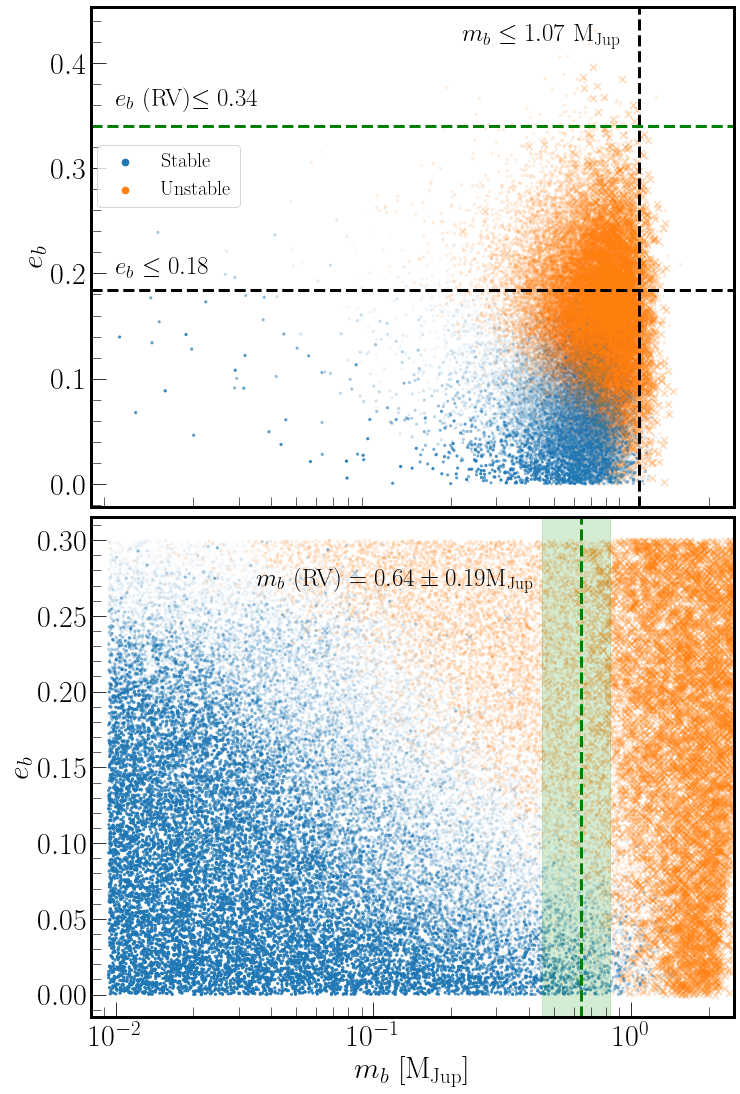

In [287]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30

# stable, in MMR
ax1.scatter(mb_array[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] < 0],
            eb_array[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] < 0],
            alpha=spock_prob_rv2[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mb_array[spock_prob_rv2 > 0.0][(np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] >= 0) | np.isnan(deltaH_db_rv2)],
            eb_array[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] >= 0],
            alpha=spock_prob_rv2[spock_prob_rv2 > 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 > 0.0] >= 0],
            c='C0',marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] < 0],
            eb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] < 0], 
            alpha=0.3,c='C1',marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] >= 0],
            eb_array[spock_prob_rv2 == 0.0][np.array(deltaH_db_rv2)[spock_prob_rv2 == 0.0] >= 0], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mb_array_logu[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] < 0],
            eb_array_logu[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] < 0],
      alpha=spock_prob_logu2[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] >= 0],
            eb_array_logu[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] >= 0],
      alpha=spock_prob_logu2[spock_prob_logu2 > 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 > 0.0] >= 0],
            c='C0',marker='o',s=5,zorder=1)

ax2.scatter(mb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] < 0],
            eb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] < 0], 
            alpha=0.3,c='C1',marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] >= 0],
            eb_array_logu[spock_prob_logu2 == 0.0][np.array(deltaH_db_logu2)[spock_prob_logu2 == 0.0] >= 0], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='C2')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.22,0.42,r'$m_b \leq {}$'.format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.01,0.20,r'$e_b$' + "~$\leq {}$".format(0.18),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

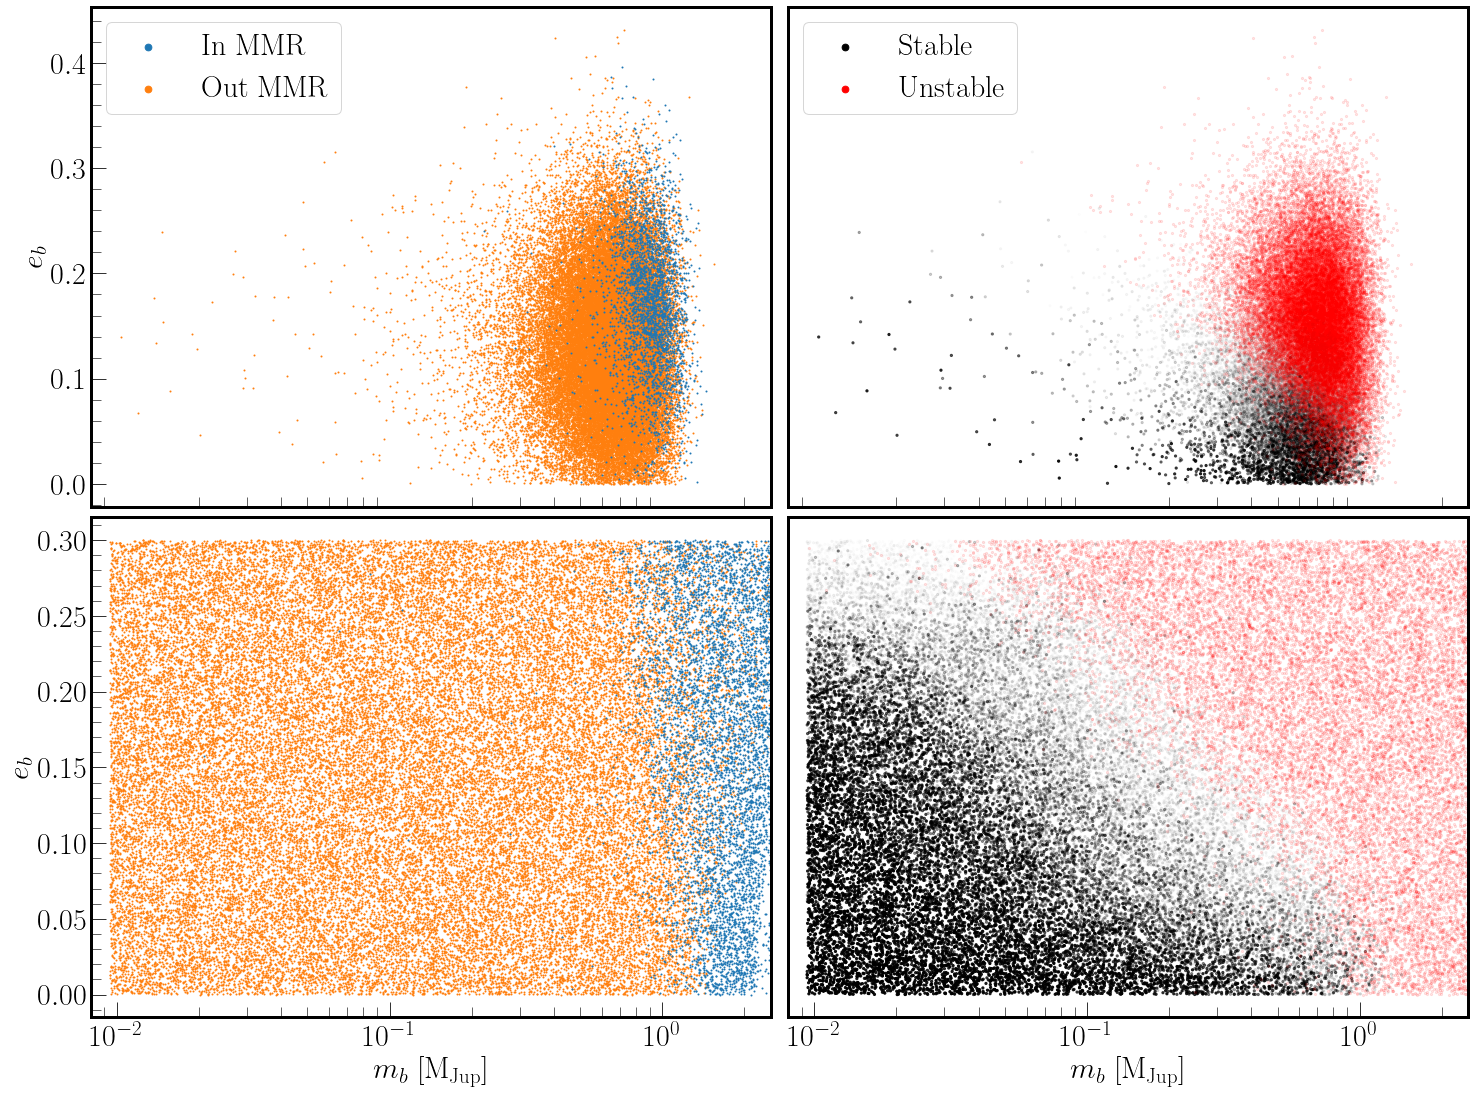

In [171]:
fig = plt.figure(1,figsize=(6*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

alpha1 = 0.4
alpha2 = 1.0
size = 30

ax1.scatter(mb_array[np.array(deltaH_db_rv2) < 0],eb_array[np.array(deltaH_db_rv2) < 0], s=1,
            zorder=1, label='In MMR') # in MMR
ax1.scatter(mb_array[np.array(deltaH_db_rv2) > 0],eb_array[np.array(deltaH_db_rv2) > 0], s=1,
            zorder=0, label='Out MMR') # out MMR
#ax1.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size)
ax1.set_ylabel('$e_b$',fontsize=size)
#ax1.set_xlim(-5.2, -2.5)
ax1.set_xscale('log')
ax1.minorticks_on()

ax2.scatter(mb_array[spock_prob_rv2 > 0.0],eb_array[spock_prob_rv2 > 0.0],
            alpha=spock_prob_rv2[spock_prob_rv2 > 0.0],c='k',s=5, label='Stable')
ax2.scatter(mb_array[spock_prob_rv2 == 0.0],eb_array[spock_prob_rv2 == 0.0], alpha=0.1,c='r',s=5,label='Unstable')
#ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size)
#ax2.set_ylabel('$e_b$',fontsize=size)
#ax2.set_xlim(-5.2, -2.5)
ax2.set_xscale('log')
ax2.minorticks_on()

ax3.scatter(mb_array_logu[np.array(deltaH_db_logu2) < 0],eb_array_logu[np.array(deltaH_db_logu2) < 0], 
            s=1,zorder=1) # in MMR
ax3.scatter(mb_array_logu[np.array(deltaH_db_logu2) > 0],eb_array_logu[np.array(deltaH_db_logu2) > 0], 
            s=1,zorder=0) # out MMR
ax3.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size)
ax3.set_ylabel('$e_b$',fontsize=size)
#ax3.set_xlim(-5.2, -2.5)
ax3.set_xscale('log')
ax3.minorticks_on()


ax4.scatter(mb_array_logu[spock_prob_logu2 > 0.0],eb_array_logu[spock_prob_logu2 > 0.0],
         alpha=spock_prob_logu2[spock_prob_logu2 > 0.0],c='k',s=5)
ax4.scatter(mb_array_logu[spock_prob_logu2 == 0.0],eb_array_logu[spock_prob_logu2 == 0.0], alpha=0.1,c='r',s=5)
ax4.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size)
#ax4.set_ylabel('$e_b$',fontsize=size)
#ax4.set_xlim(-5.2, -2.5)
ax4.set_xscale('log')
ax4.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax3.set_xlim(8e-3, 2.5)
ax4.set_xlim(8e-3, 2.5)
ax4.set_yticks([])


ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':30})
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]
    
leg2 = ax2.legend(prop={'size':30})
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

ax3.tick_params(axis='y', labelsize=30)
ax3.tick_params(axis='x', labelsize=30)

ax4.tick_params(axis='y', labelsize=30)
ax4.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.show()

### Figure 2

In [312]:
rv_inres_deltaT = [param[:4] for param in rv_inres]

In [313]:
rv_inres_deltaT[0]

array([ 4.02907126e-02,  1.08298120e-03, -4.10742393e+00,  8.28455758e+02])

In [315]:
j=3
k=1
phi_rv2, Phinorm_rv2 = get_Phinorm(rv_inres_deltaT)

18it [00:00, 42.43it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
10591it [04:00, 44.02it/s]


In [319]:
print(len(phi_rv2))
print(len(spock_inres_rv))

10591
10591


<ipython-input-391-2ef16b55fdb7>:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2a.pdf',dpi=300,bbox_inches='tight',padding=0)


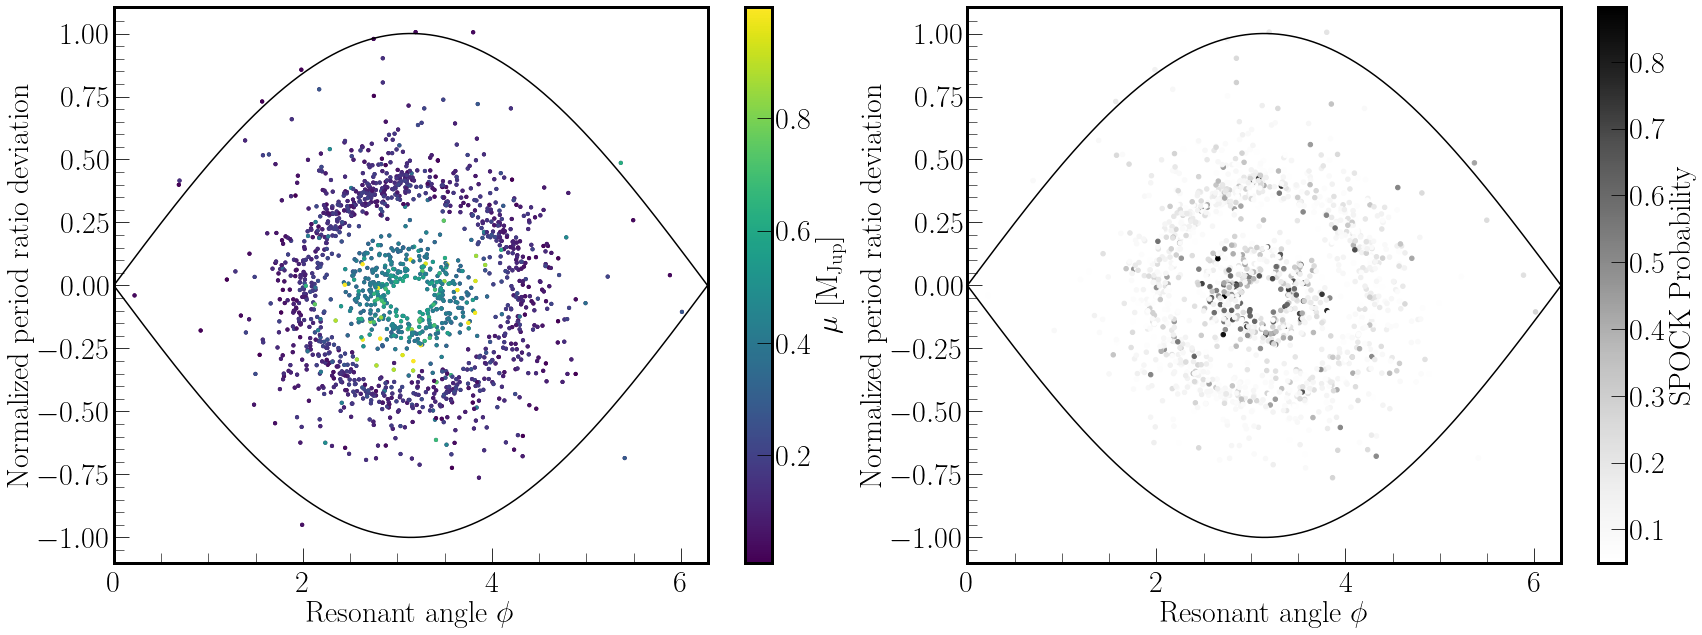

In [391]:
fig = plt.figure(1,figsize=(7*3.4, 3.5*3.4*3/4.))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)

cb=ax1.scatter(phi_rv2[spock_inres_rv >= 0.05], Phinorm_rv2[spock_inres_rv >= 0.05], 
              c=[(10**(param[2]))/1e-3 for param in rv_inres[spock_inres_rv >= 0.05]], 
              s=10)
ax1.scatter(phi_rv2[spock_inres_rv >= 0.05], Phinorm_rv2[spock_inres_rv >= 0.05], 
              c=[param[2] for param in rv_inres[spock_inres_rv >= 0.05]], 
              s=10)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv2[spock_inres_rv >= 0.05], Phinorm_rv2[spock_inres_rv >= 0.05], 
              c=[prob for prob in spock_inres_rv[spock_inres_rv >= 0.05]],cmap='Greys', 
              s=20) 

cbar2 = fig.colorbar(cb2, ax=ax2)
cbar2.set_label(r'SPOCK Probability', fontsize=30)
cbar2.ax.tick_params(labelsize=30)
#fig.colorbar(cb2, ax=ax2).set_label(r'SPOCK Probability', fontsize=30)

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.savefig('figures/Figure2a.pdf',dpi=300,bbox_inches='tight',padding=0)


In [370]:
rv_inres_deltaT[0]

array([ 4.02907126e-02,  1.08298120e-03, -4.10742393e+00,  8.28455758e+02])

1000it [00:16, 59.12it/s]
<ipython-input-389-126b9fbaf6cd>:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)


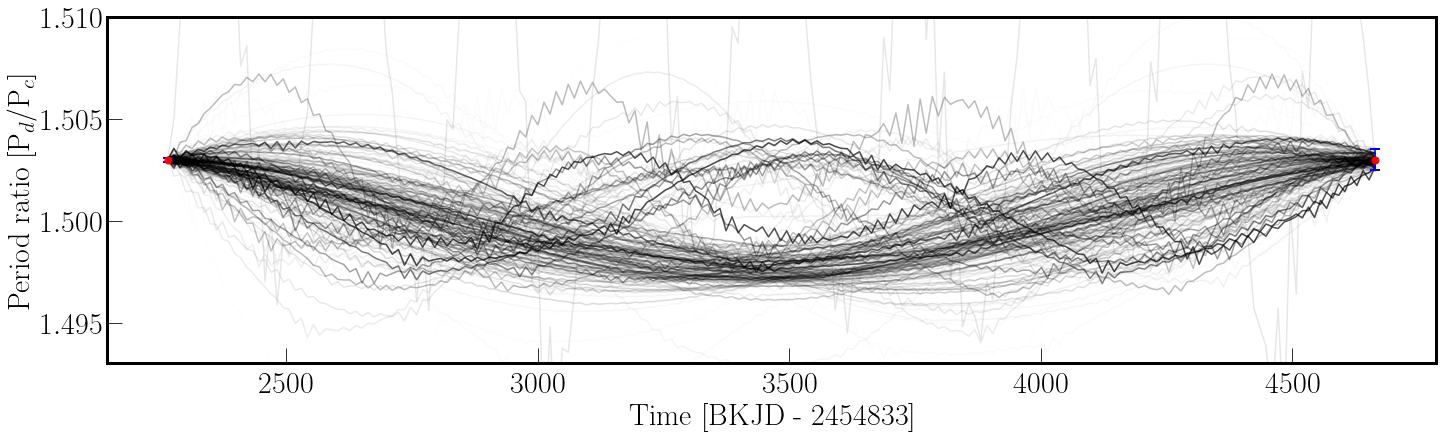

In [389]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres_deltaT[:1000])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=spock_inres_rv[i],zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

100it [00:01, 56.48it/s]


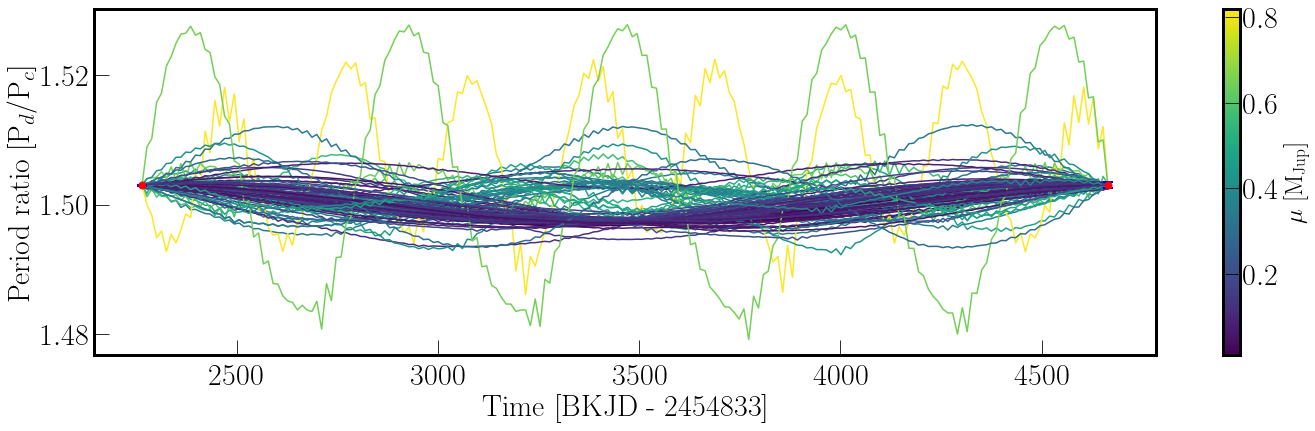

In [439]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

size=100

c_mu = np.array([param[-2] for param in rv_inres_deltaT[:size]])
c_mu2 = np.array([(10**param[-2])/9.54e-4 for param in rv_inres_deltaT[:size]])
norm = mpl.colors.Normalize(vmin=c_mu.min(), vmax=c_mu.max())
norm2 = mpl.colors.Normalize(vmin=c_mu2.min(), vmax=c_mu2.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.viridis)
cmap.set_array([])
cmap2.set_array([])

for i,param in tqdm(enumerate(rv_inres_deltaT[:size])):
    p = param
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    #cb_pratio = ax.plot(time_grid,period_ratios,
    #     alpha=1.0,zorder=0, c=cmap.to_rgba((10**c_mu[i])/9.54e-4),
    #     rasterized=True)
    ax.plot(time_grid,period_ratios,
         alpha=1.0,zorder=0, c=cmap.to_rgba(c_mu[i]),
         rasterized=True)
    



#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

t_cbar = fig.colorbar(cmap2)
t_cbar.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=25)
t_cbar.ax.tick_params(labelsize=30)
plt.show()
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

In [382]:
1.503-0.01

1.4929999999999999

## Prior sensitivity tests: Lowering the mass of planet b in log uniform sampling to see how much it changes

### Original limits (3 $M_\oplus$, 3 $M_\rm{Jup}$)

In [14]:
Nsamps = 25000

In [15]:
simlist_logu, indices_logu = sampler(Nsamps, like_output, e_b=True)

100%|██████████| 25000/25000 [03:01<00:00, 137.48it/s]


In [16]:
s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu, indices_logu, 0.95, 
                                                               like_output, ecc_b=True)

In [27]:
sigma_list_logu = [float(DescrStatsW(data=np.array(s_results_logu)[:,i], 
                         weights=preds_logu).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu)[1])]

In [29]:
sigma_list_logu[2]

-3.1940014423446743

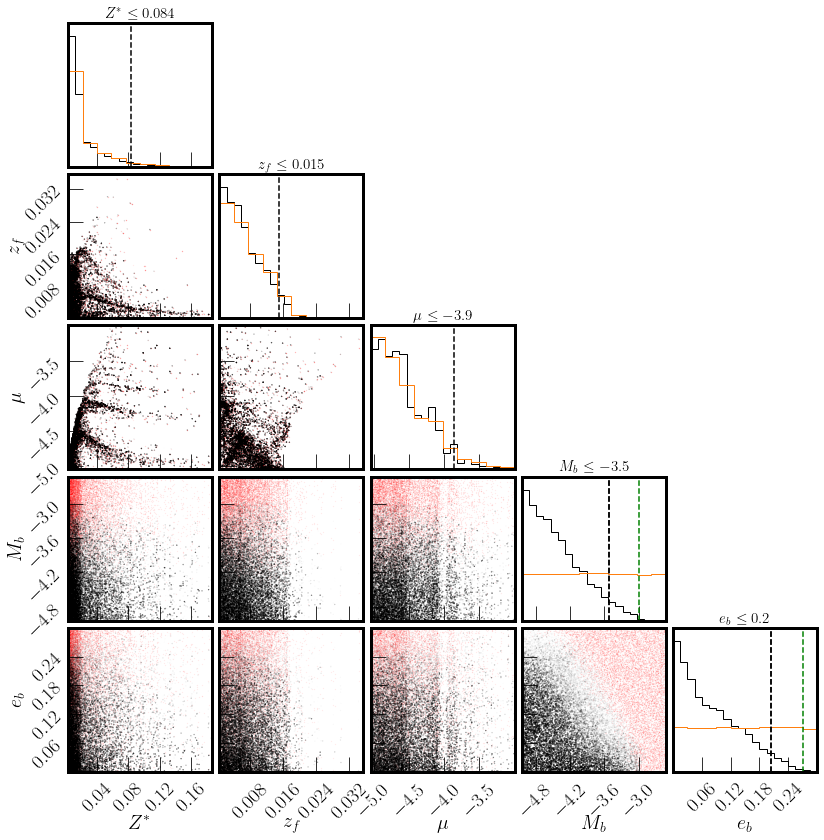

In [17]:
corner_plot(s_results_logu, preds_logu, sigma_list_logu, pl_b=True, ecc_b=True,
            labels=["$Z^*$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )

### Changed limits (0.1 $M_\oplus$, 3 $M_\rm{Jup}$)

In [19]:
simlist_logu2, indices_logu2 = sampler(Nsamps, like_output, bmass_lims=[3.00273e-7, 3e-3],e_b=True)

100%|██████████| 25000/25000 [03:02<00:00, 136.77it/s]


In [20]:
s_results_logu2, preds_logu2, sigma_list_logu2 = weighted_results(simlist_logu2, indices_logu2, 0.95, 
                                                               like_output, ecc_b=True)

In [30]:
sigma_list_logu2 = [float(DescrStatsW(data=np.array(s_results_logu2)[:,i], 
                         weights=preds_logu2).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu2)[1])]

In [31]:
sigma_list_logu2[2]

-3.30032361251335

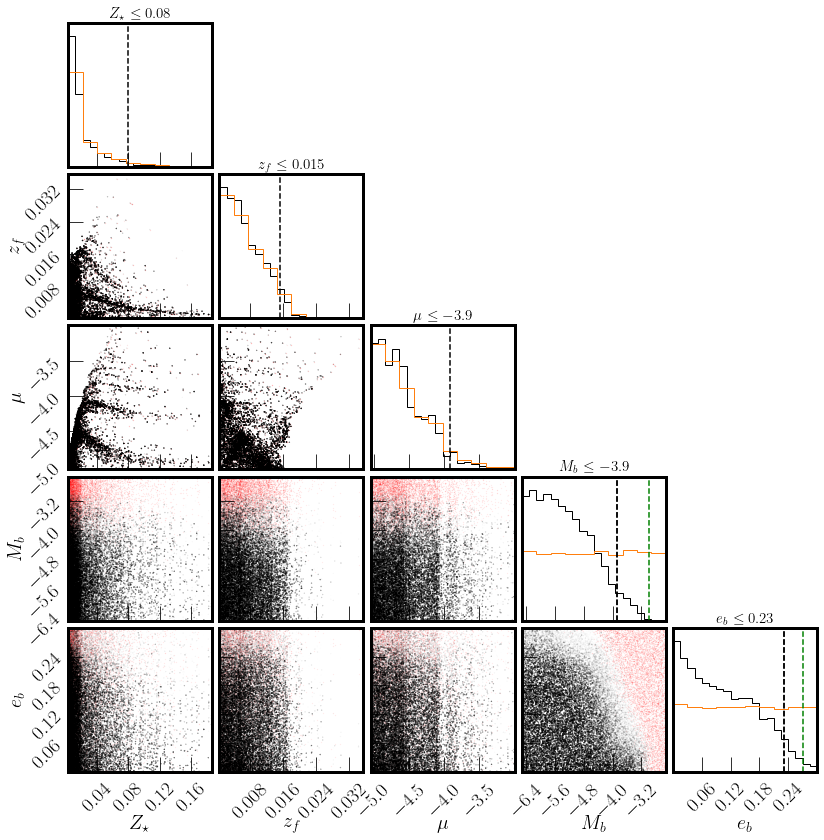

In [22]:
corner_plot(s_results_logu2, preds_logu2, sigma_list_logu2, pl_b=True, ecc_b=True,
            labels=["$Z_\star$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )

### Changed limits (3 $M_\oplus$, 10 $M_\rm{Jup}$)

In [23]:
simlist_logu3, indices_logu3 = sampler(Nsamps, like_output, bmass_lims=[8.964e-6, 3e-2],e_b=True)

100%|██████████| 25000/25000 [03:02<00:00, 136.89it/s]


In [24]:
s_results_logu3, preds_logu3, sigma_list_logu3 = weighted_results(simlist_logu3, indices_logu3, 0.95, 
                                                               like_output, ecc_b=True)

In [32]:
sigma_list_logu3 = [float(DescrStatsW(data=np.array(s_results_logu3)[:,i], 
                         weights=preds_logu3).quantile(probs=np.array([0.997]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results_logu3)[1])]

In [33]:
sigma_list_logu3[2]

-3.193458933940142

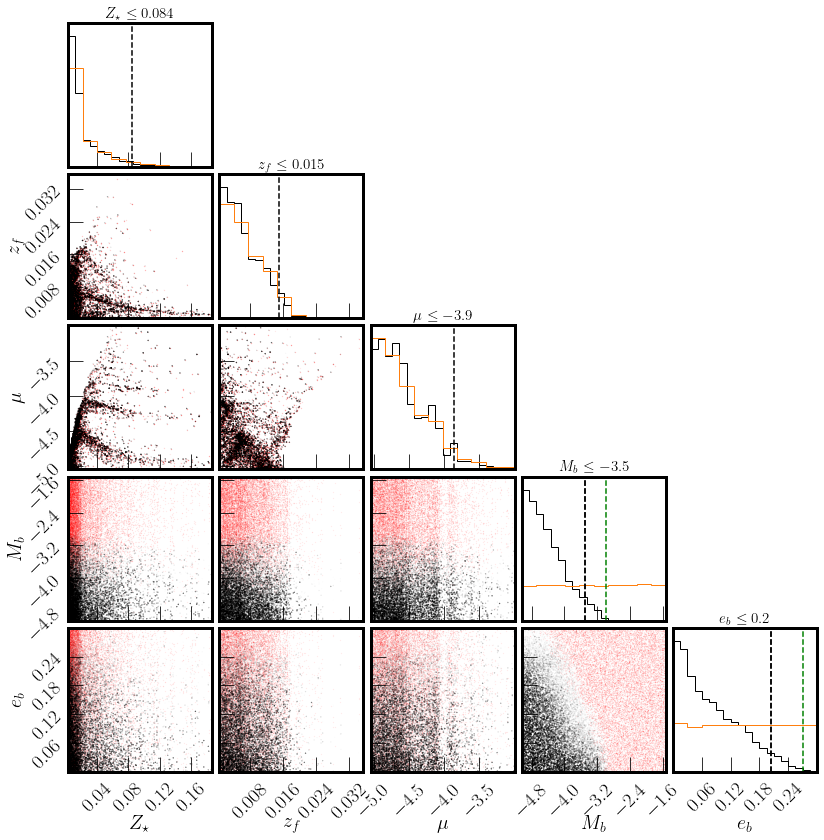

In [25]:
corner_plot(s_results_logu3, preds_logu3, sigma_list_logu3, pl_b=True, ecc_b=True,
            labels=["$Z_\star$", "$z_f$", "$\mu$", "$M_b$", "$e_b$"], 
           )